# Module 2 Assignment

# Tasks
## What trends do you see in the force plate data?
## How would you report this to a coach for actionable information?
- Season's worth of data for a track and field team
- Hands-on-hips protocol
- Position Feature
-- Athlete's category
- Video suggestions:
-- Left / Right asymmetries, or
-- Evaluating metrics covered in video
-- No requirement to look at all features, but
-- Can also look at one feature such as jump height, or
-- Look at how different positions perform
- 

# Imports

In [1016]:
import re
import pandas as pd
import numpy as np
import scipy
from scipy import stats
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
from pathlib import Path
import matplotlib.pyplot as plt
import streamlit as st
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'notebook'
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)
import seaborn as sns
sns.set_theme(style="white")

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import TransformedTargetRegressor, make_column_transformer, ColumnTransformer, make_column_selector
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_score, adjusted_rand_score,r2_score, mean_squared_error, accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, roc_curve, precision_recall_curve, auc, confusion_matrix
from sklearn.model_selection import RepeatedKFold, cross_val_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, plot_tree, DecisionTreeClassifier

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBRFClassifier

In [1017]:
project_path = Path.cwd()
print(f'project_path: {project_path}')
print('')
project_data_sources_path = Path.cwd() / 'data' / 'sources'
print(f'project_data_sources_path: {project_data_sources_path}')
print('')
project_data_exports_path = Path.cwd() / 'data' / 'exports'
print(f'project_data_exports_path: {project_data_exports_path}')

project_path: /Users/chrisizenour/Library/CloudStorage/Dropbox/My Mac (Chriss-MBP.home)/Desktop/python/projects/msu/petway_1/module_2

project_data_sources_path: /Users/chrisizenour/Library/CloudStorage/Dropbox/My Mac (Chriss-MBP.home)/Desktop/python/projects/msu/petway_1/module_2/data/sources

project_data_exports_path: /Users/chrisizenour/Library/CloudStorage/Dropbox/My Mac (Chriss-MBP.home)/Desktop/python/projects/msu/petway_1/module_2/data/exports


# User Defined Functions

## Dataset Import and Wrangling

In [1018]:
def load_dataset():
    df = pd.read_excel(
        project_data_sources_path / 'WestChester.xlsx',
        sheet_name='WestChester',
        # header=1
    )
    # df = df.iloc[:-2]
    print(f'Shape of dataframe: {df.shape[0]} rows, {df.shape[1]} columns')
    return df

In [1019]:
def clean_df_columns(df):
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.strip()
    df.columns = df.columns.str.replace('%', 'pct', regex=False)
    df.columns = df.columns.str.replace('|', '_', regex=False)
    df.columns = df.columns.str.replace('.', '')
    df.columns = df.columns.str.replace('-', '')
    df.columns = df.columns.str.replace(' ', '_')
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df['date_str'] = df['date'].dt.strftime('%Y-%m-%d')
    df = df.sort_values(by=['date', 'name', 'time'], ascending=[True, True, True])
    df['position'] = df['position'].fillna('Unassigned')
    return df

In [1020]:
def rearrange_cols(df):
    df = df.iloc[:, np.r_[0, 1, 85, 2:84]]
    return df

In [1021]:
def create_zscore_cols(df):
    df['jump_height_zscore'] = stats.zscore(df['jump_height'])
    df['takeoff_velocity_zscore'] = stats.zscore(df['takeoff_velocity'])
    df['countermovement_depth_zscore'] = stats.zscore(df['countermovement_depth'])
    df['unweighting_phase_zscore'] = stats.zscore(df['unweighting_phase'])
    df['time_to_takeoff_zscore'] = stats.zscore(df['time_to_takeoff'])
    return df

In [1022]:
def drop_2zscore_outliers(df):
    # print(f'Outlier Observations: {df.loc[(df['jump_height_zscore'] > 2) | (df['jump_height_zscore'] < -1), :].shape}')
    condition = (
        (df['jump_height_zscore'].abs() > 2) |
        (df['takeoff_velocity_zscore'].abs() > 2) |
        (df['countermovement_depth_zscore'].abs() > 2) |
        (df['unweighting_phase_zscore'].abs() > 2) |
        (df['time_to_takeoff_zscore'].abs() > 2)
    )
    outlier_df = df.loc[condition]
    df = df.loc[~condition].reset_index(drop=True)
    return df, outlier_df

In [1023]:
def drop_subsequent_jump_observations(df):
    df = df.drop_duplicates(subset=['date', 'name'], keep='first')
    return df

In [1024]:
def drop_specific_null_obs(df):
    df = df.loc[df['rsi'].notnull(), :]
    df = df.loc[df['landing_stiffness'].notnull(), :]
    df = df.loc[df['peak_landing_force'].notnull(), :]
    df = df.loc[df['avg_landing_force'].notnull(), :]
    df = df.loc[df['relative_peak_landing_force'].notnull(), :]
    df = df.loc[df['flight_time'].notnull(), :]
    return df

In [1025]:
columns = ['testid',
           'date',
           'date_str',
           'time',
           'name',
           'position',
           'takeoff_velocity', 
           'system_weight',
           'countermovement_depth',
           'time_to_takeoff',
           'unweighting_phase',
           'braking_phase',
           'peak_braking_power',
           'force_at_min_displacement',
           'propulsive_phase',
           'peak_propulsive_power',
           ]

In [1026]:
def columns_to_keep(df):
    df = df.loc[:, columns]
    return df

In [1027]:
# def columns_to_keep(df):
#     df = df.loc[:, ['testid',
#                     'date',
#                     'date_str',
#                     'time',
#                     'name',
#                     'position',
#                     'type',
#                     'jump_height',
#                     'jump_height_zscore',
#                     'system_weight',
#                     'countermovement_depth',
#                     'jump_momentum',
#                     'takeoff_velocity',
#                     'takeoff_velocity_zscore',
#                     'time_to_takeoff', 
#                     'unweighting_phase',
#                     'braking_phase',
#                     'peak_braking_power',
#                     'peak_relative_braking_power',
#                     'avg_braking_power', 'avg_relative_braking_power',
#                     'force_at_min_displacement',
#                     'propulsive_phase',
#                     'peak_propulsive_power',
#                     'peak_relative_propulsive_power',
#                     'avg_propulsive_power',
#                     'avg_relative_propulsive_power']]
#     return df

In [1028]:
# def drop_cols(df):
#     df = df.drop(['relative_force_at_min_displacement', 
#                   'peak_braking_velocity',
#                   'time_to_stabilization',
#                   'l_r_landing_impulse_index'], axis=1)
#     return df

# Corr & Pval Analysis

In [1029]:
def correlation_matrix(df):
    """create correlation matrix dataframe"""
    df_corr_mat = df.corr()
    return df_corr_mat

In [1030]:
def correlation_series(df):
    """create a dataframe which has unique feature pairs and their associated correlation coefficient"""
    upper_corr_mat = df.where(np.triu(np.ones(df.shape), k=1).astype(bool))
    unique_corr_pairs = upper_corr_mat.unstack().dropna()
    df_corr_series = unique_corr_pairs.sort_values(ascending=False)
    df_corr_series = df_corr_series.reset_index()
    df_corr_series = df_corr_series.rename(columns={
        'level_0': 'feature_1',
        'level_1': 'feature_2',
        0: 'correlation_coefficient'
    })
    return df_corr_series

In [1031]:
def correlation_plot(df, title='Correlation Heatmap'):
    """create a correlation heatmap plot using seaborn"""
    mask = np.triu(np.ones_like(df, dtype=bool))
    f, ax = plt.subplots(1, 1, figsize=(11,9))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(df,
                mask=mask,
                cmap=cmap,
                vmax=1,
                vmin=-1,
                center=0,
                annot=False,
                square=True,
                linewidths=0.5,
                cbar_kws={'shrink': 0.5})
    ax.set_title(title)
    ax.set_xlabel('Variables')
    ax.set_ylabel('Variables')

    plt.tight_layout() 
    return f

In [1032]:
def p_val_matrix(df):
    """create p-value matrix dataframe"""
    df_p_val_mat = df.corr(method=lambda x, y: stats.pearsonr(x, y)[1]) - np.eye(len(df.columns))
    return df_p_val_mat

In [1033]:
def p_val_series(df):
    """create a dataframe which has unique feature pairs and their associated level of statistical significance"""
    upper_corr_mat = df.where(np.triu(np.ones(df.shape), k=1).astype(bool))
    unique_p_val_pairs = upper_corr_mat.unstack().dropna()
    df_p_val_series = unique_p_val_pairs.sort_values()
    df_p_val_series = df_p_val_series.reset_index()
    df_p_val_series = df_p_val_series.rename(columns={
        'level_0': 'feature_1',
        'level_1': 'feature_2',
        0: 'p_value'
    })
    return df_p_val_series

In [1034]:
def p_val_plot(df, title="P-value Heatmap (Green: Significant, White: Not Significant"):
    """create a level of statistical significance heatmap plot using seaborn"""
    alpha = 0.05
    mask = np.triu(np.ones_like(df, dtype=bool))
    f, ax = plt.subplots(1, 1, figsize=(11,9))
    green = sns.light_palette('seagreen', reverse=True, as_cmap=True)
    green.set_over('white')
    # cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(df,
                mask=mask,
                cmap=green,
                # cmap=cmap,
                vmax=alpha,
                vmin=0,
                # center=0,
                annot=False,
                square=True,
                linewidths=0.5,
                cbar_kws={'shrink': 0.5})
    ax.set_title(title)
    ax.set_xlabel('Variables')
    ax.set_ylabel('Variables')
    plt.tight_layout()
    return f

# Clustering

In [1035]:
def inertia_scores(df):
    inertias_list = []
    for k in range(1, 16):
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA(random_state=0)),
            ('clusterer', KMeans(n_clusters=k, n_init = 10, random_state=0))
        ]).fit(df)
        inertias_list.append(pipe.named_steps['clusterer'].inertia_)
    return inertias_list

In [1036]:
def elbow_plot(inertias):
    sns.set_theme(style='white')
    fig, ax = plt.subplots(figsize=(10, 6))  # Create a figure and a set of subplots
    sns.lineplot(x=range(len(inertias)), y=inertias, marker='o', linestyle='-', ax=ax)
    ax.set_title('Elbow Plot')
    ax.set_xlabel('K')
    ax.set_ylabel('Inertia')
    plt.show()
    return fig  # Return the figure object for further manipulation if needed

In [1037]:
def silhouette_scores(df):
    """calculate and create a dataframe containing the silhouette score for each k value"""
    silhouette_score_list = []
    for k in range(2, 16):
        pipe = Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('pca', PCA(random_state=0)),
            ('clusterer', KMeans(n_clusters=k, random_state=0))]).fit(df)
        cluster_labels = pipe.named_steps['clusterer'].labels_
        silhouette_avg = silhouette_score(df, cluster_labels)
        silhouette_score_list.append(silhouette_avg)
    silhouette_df = pd.DataFrame(silhouette_score_list, columns=['silhouette_score'])
    silhouette_df['k'] = [k for k in range(2, 16)]
    return silhouette_df


In [1038]:
def silhouette_score_plot(df):
    sns.set_theme(style='white')  # Set the theme of the plot
    fig, ax = plt.subplots(figsize=(10, 6))  # Create a figure and an axes object

    # Create the line plot
    sns.lineplot(data=df, x='k', y='silhouette_score', ax=ax, marker='o', linestyle='-')

    ax.set_title('Average Cluster Silhouette Score')  # Set the title
    ax.set_xlabel('Number of Clusters (K)')  # Set the x-axis label
    ax.set_ylabel('Silhouette Score')  # Set the y-axis label

    return fig  # Return the figure object

In [1039]:
def pca_cumsum_exp_var_ratios(df):
    """calculate and create a dataframe containing each feature's explained variance ratio, the cumulative sum of explained variance ratios"""
    pca_feature_exp_var = []
    pca_feature_cumsum_exp_var = []
    pca_qty = []
    pca = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('pca', PCA(random_state=0))]).fit(df)
    pca_feature_exp_var.append(pca.named_steps['pca'].explained_variance_ratio_)
    pca_feature_cumsum_exp_var.append(np.cumsum(pca.named_steps['pca'].explained_variance_ratio_))
    pca_qty.append(list(range(len(df.columns))))
    pca_df = pd.DataFrame({'principal_component_qty': pca_qty,
                           'feature_explained_variance': pca_feature_exp_var,
                           'feature_cumsum_explained_variance': pca_feature_cumsum_exp_var,
                           })
    pca_df = pca_df.explode(['principal_component_qty',
                             'feature_explained_variance',
                             'feature_cumsum_explained_variance',
                             ])
    pca_df = pca_df.reset_index(drop=True)
    return pca_df


In [1040]:
def scree_plot(df):
    sns.set_theme(style='white')  # Set the theme of the plot
    fig, ax = plt.subplots(figsize=(10, 6))  # Create a figure and an axes object

    # Create the line plot
    sns.lineplot(data=df, x=df.index, y='feature_cumsum_explained_variance', ax=ax, marker='o', linestyle='-')

    ax.set_title('Scree Plot, Cumulative Sum of PCA Explained Variance Ratios')  # Set the title
    ax.set_xlabel('Number of Principal Components')  # Set the x-axis label
    ax.set_ylabel('Cumulative Sum Explained Variance Ratios')  # Set the y-axis label

    return fig  # Return the figure object

In [1041]:
def pca_matrix_heatmap(df):
    pca_pipe = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('pca', PCA(random_state=0))]).fit(df)
    pca_pipe.named_steps['pca'].components_**2

    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    sns.heatmap(
        pca_pipe.named_steps['pca'].components_**2,
        yticklabels=['PCA'+str(x) for x in range(1, pca_pipe.named_steps['pca'].n_components_+1)],
        xticklabels=list(df.columns),
        annot=True,
        fmt='.2f',
        square=True,
        linewidth=0.05,
        linecolor='white',
        cbar_kws={'orientation': 'vertical'},
        vmin=0,
        vmax=1,
        ax=ax,
    )
    return fig


In [1042]:
def pca_cluster_df(df, components, clusters):
    """calculate and create a dataframe containing the first two principal components and the associated cluster label"""
    pipe = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('pca', PCA(random_state=0, n_components=components)),
        ('clusterer', KMeans(random_state=0, n_clusters=clusters))])
    pipe.fit(df)
    labels = pipe.named_steps['clusterer'].labels_
    labels = labels.astype(str)
    pc_1 = pipe[0:2].fit_transform(df)[:, 0]
    pc_2 = pipe[0:2].fit_transform(df)[:, 1]
    centroids_x = pipe.named_steps['clusterer'].cluster_centers_[:, 0]
    centroids_y = pipe.named_steps['clusterer'].cluster_centers_[:, 1]
    cluster_dict = {
        'pc_1': pc_1,
        'pc_2': pc_2,
        'label': labels
    }
    cluster_df = pd.DataFrame(cluster_dict)
    return cluster_df, centroids_x, centroids_y


In [1043]:
def merge_cluster_df(df1, df2):
    """create a merged dataframe that combines the cleaned dataframe and the pca_cluster dataframe so each observation has its first two principal components and cluster label"""
    df_labeled = pd.concat([df1, df2], axis=1)
    df_labeled = df_labeled.sort_values(by=['label'])
    df_labeled = df_labeled.reset_index(drop=True)
    return df_labeled

In [1044]:
def pc12_cluster_plot(df, df_2, centroids_x, centroids_y):
    # Set the theme of the plot
    sns.set_theme(style='white')

    # Create a figure and an axes object
    fig, ax = plt.subplots(figsize=(10, 6))

    # Create the scatter plot for the clusters
    sns.scatterplot(data=df, x='pc_1', y='pc_2', hue='label', style='label', palette='deep', ax=ax, s=50, alpha=0.5)

    # Plot the centroids
    ax.scatter(centroids_x, centroids_y, color='black', s=100, marker='*', label='centroids')

    # Set the title and labels with explained variance
    title = f"Cluster Plot Projection of 2 Principal Components, Explained Variance: {round(df_2['feature_explained_variance'][0] + df_2['feature_explained_variance'][1], 3)}"
    ax.set_title(title)
    ax.set_xlabel(f"PC 1, Explained Variance: {round(df_2['feature_explained_variance'][0], 3)}")
    ax.set_ylabel(f"PC 2, Explained Variance: {round(df_2['feature_explained_variance'][1], 3)}")

    # Add legend
    ax.legend()

    # Return the figure object
    return fig

# Dataset Imports

In [1045]:
df = load_dataset()
df = clean_df_columns(df)
df = rearrange_cols(df)
df = create_zscore_cols(df)
df = drop_subsequent_jump_observations(df)
df, outliers_df = drop_2zscore_outliers(df)
df = columns_to_keep(df)
df

Shape of dataframe: 608 rows, 85 columns


,testid,date,date_str,time,name,position,takeoff_velocity,system_weight,countermovement_depth,time_to_takeoff,unweighting_phase,braking_phase,peak_braking_power,force_at_min_displacement,propulsive_phase,peak_propulsive_power
0,OyBSC2ipcJDyXN1GBbfO,2022-03-22,2022-03-22,13:16:37,Aaron Williams,Sprints,3.2793,723.7908,-0.3716,1.086,0.588,0.238,-657.1589,1530,0.260,5509.0807
1,XHZJP0SoALY7n7WKHLZ5,2022-03-22,2022-03-22,14:07:05,Ammare Mayo,Sprints,3.0043,668.6937,-0.2793,0.673,0.315,0.132,-1391.1700,1843,0.226,4438.9458
2,ualCP0CeBSnJTb6HK0ge,2022-03-22,2022-03-22,12:59:59,Andrew Bosche,PV,2.6888,711.4374,-0.3135,0.916,0.396,0.195,-792.5835,1395,0.325,3730.7445
3,NKonsoCVgxjGBwD4JnLr,2022-03-22,2022-03-22,14:02:19,Chad Mowbray,Sprints,3.0468,744.8048,-0.4278,0.909,0.386,0.244,-1049.4055,1735,0.279,4820.3112
4,D9w5963nreWH7W3oneHV,2022-03-22,2022-03-22,14:03:20,Chase Knnor,Distance,2.6148,724.2543,-0.4430,1.005,0.399,0.244,-1145.4309,1373,0.362,3472.5154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,V0zaVvVWSXxF5rWYYcg5,2022-05-10,2022-05-10,13:11:00,Nick Page,Jumps,2.7237,770.9199,-0.2398,0.712,0.344,0.159,-1082.5908,1667,0.209,4846.5209
543,SnsQAejv3g5u7mDC9i7Q,2022-05-10,2022-05-10,13:18:37,Orion Frazier,Sprints,2.9729,888.7668,-0.3474,0.697,0.327,0.134,-2664.2897,2413,0.236,5748.4795
544,ugKiBtwelKxSroj9w87j,2022-05-10,2022-05-10,13:23:04,Terrance Gainer,Sprints,2.8829,749.5766,-0.2507,0.724,0.372,0.147,-1411.2698,1860,0.205,4858.5551
545,xCnD65gW6xtBl1LfXDFl,2022-05-10,2022-05-10,13:09:31,Will Rivers,Jumps,2.9127,720.0120,-0.4150,0.724,0.302,0.196,-1675.3063,1714,0.226,4747.4210


In [1046]:
outliers_df

,testid,date,date_str,time,name,position,type,system_weight,jump_height,jump_momentum,...,braking_impulse,relative_braking_impulse,relative_braking_net_impulse,propulsive_impulse,relative_propulsive_impulse,jump_height_zscore,takeoff_velocity_zscore,countermovement_depth_zscore,unweighting_phase_zscore,time_to_takeoff_zscore
49,BY6Rt4K4P1viLqcC3fJj,2022-03-22,2022-03-22,13:55:39,Amir Cubbage,Distance,Countermovement Jump,651.0320,0.4413,195.2656,...,164.1055,2.4728,1.0405,376.5275,5.6737,0.190712,0.259510,-0.621589,2.513214,1.738631
187,ZAmctL8FKSaRGXqbBrw4,2022-03-22,2022-03-22,14:24:14,Cole Smith,Distance,Countermovement Jump,637.0881,0.4265,187.8722,...,261.7805,4.0309,1.1959,413.7230,6.3706,0.041773,0.100043,-1.584091,1.232419,2.201324
237,yahCwjsGJ8KJbxdK3Sru,2022-03-22,2022-03-22,14:17:16,Jack Wasserman,Sprints,Countermovement Jump,841.0941,0.5450,280.3652,...,1233.1765,14.3830,0.2958,665.6635,7.7639,1.234291,1.317350,0.292595,1.641184,9.883217
477,DSqHOrZ6083QeJNuy32B,2022-03-22,2022-03-22,13:23:46,Tyrese Reid,Jumps,Countermovement Jump,591.1602,0.3719,162.7827,...,52.9110,0.8780,0.3189,263.5210,4.3730,-0.507691,-0.518456,2.665994,-1.728853,-2.200193
21,Z81eAHZ7InfT8vgynq4N,2022-03-23,2022-03-23,14:02:03,Aaron Williams,Sprints,Countermovement Jump,339.3163,0.7086,128.9652,...,162.3345,4.6933,0.8674,223.4440,6.4600,2.880671,2.797423,-1.730013,1.386841,2.450467
78,OCouzO1zA5S1d76udEmp,2022-03-23,2022-03-23,13:27:39,Ammare Mayo,Sprints,Countermovement Jump,300.4995,0.3042,74.8390,...,128.2135,4.1856,2.2727,128.6430,4.1996,-1.188986,-1.351622,-17.574578,10.397828,6.585045
168,8iWOxuKVmKHPmBoGaJgR,2022-03-23,2022-03-23,13:59:12,Chad Mowbray,Sprints,Countermovement Jump,355.1161,0.7343,137.4017,...,140.2405,3.8741,1.3137,245.6390,6.7857,3.139302,3.014350,-1.352163,-0.538894,0.581898
175,THlgJhyQDnqNCViMUmhK,2022-03-23,2022-03-23,14:00:16,Chase Knnor,Distance,Countermovement Jump,399.5275,0.2065,81.9783,...,157.2905,3.8621,1.0270,216.3320,5.3118,-2.172185,-2.740663,-1.098975,-0.211882,1.145435
196,zlXDJoRZETQKd0JSAgkI,2022-03-23,2022-03-23,12:31:39,David Kramer,Distance,Countermovement Jump,255.6186,1.7251,151.5911,...,79.9800,3.0694,0.6267,358.8660,13.7724,13.110163,9.541518,0.889810,0.778236,4.372423
236,s8eJNbo187IM4nneKLeK,2022-03-23,2022-03-23,13:58:24,Jack Wasserman,Sprints,Countermovement Jump,400.4014,0.7208,153.4954,...,108.8365,2.6665,0.6457,301.6045,7.3894,3.003445,2.901367,1.020270,-0.620647,0.587830


# Final Useable Datasets

In [1047]:
df.to_csv(f'{project_data_exports_path}/df.csv')
df

,testid,date,date_str,time,name,position,takeoff_velocity,system_weight,countermovement_depth,time_to_takeoff,unweighting_phase,braking_phase,peak_braking_power,force_at_min_displacement,propulsive_phase,peak_propulsive_power
0,OyBSC2ipcJDyXN1GBbfO,2022-03-22,2022-03-22,13:16:37,Aaron Williams,Sprints,3.2793,723.7908,-0.3716,1.086,0.588,0.238,-657.1589,1530,0.260,5509.0807
1,XHZJP0SoALY7n7WKHLZ5,2022-03-22,2022-03-22,14:07:05,Ammare Mayo,Sprints,3.0043,668.6937,-0.2793,0.673,0.315,0.132,-1391.1700,1843,0.226,4438.9458
2,ualCP0CeBSnJTb6HK0ge,2022-03-22,2022-03-22,12:59:59,Andrew Bosche,PV,2.6888,711.4374,-0.3135,0.916,0.396,0.195,-792.5835,1395,0.325,3730.7445
3,NKonsoCVgxjGBwD4JnLr,2022-03-22,2022-03-22,14:02:19,Chad Mowbray,Sprints,3.0468,744.8048,-0.4278,0.909,0.386,0.244,-1049.4055,1735,0.279,4820.3112
4,D9w5963nreWH7W3oneHV,2022-03-22,2022-03-22,14:03:20,Chase Knnor,Distance,2.6148,724.2543,-0.4430,1.005,0.399,0.244,-1145.4309,1373,0.362,3472.5154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,V0zaVvVWSXxF5rWYYcg5,2022-05-10,2022-05-10,13:11:00,Nick Page,Jumps,2.7237,770.9199,-0.2398,0.712,0.344,0.159,-1082.5908,1667,0.209,4846.5209
543,SnsQAejv3g5u7mDC9i7Q,2022-05-10,2022-05-10,13:18:37,Orion Frazier,Sprints,2.9729,888.7668,-0.3474,0.697,0.327,0.134,-2664.2897,2413,0.236,5748.4795
544,ugKiBtwelKxSroj9w87j,2022-05-10,2022-05-10,13:23:04,Terrance Gainer,Sprints,2.8829,749.5766,-0.2507,0.724,0.372,0.147,-1411.2698,1860,0.205,4858.5551
545,xCnD65gW6xtBl1LfXDFl,2022-05-10,2022-05-10,13:09:31,Will Rivers,Jumps,2.9127,720.0120,-0.4150,0.724,0.302,0.196,-1675.3063,1714,0.226,4747.4210


In [1048]:
outliers_df.to_csv(f'{project_data_exports_path}/outliers_df.csv')
outliers_df.head()

,testid,date,date_str,time,name,position,type,system_weight,jump_height,jump_momentum,...,braking_impulse,relative_braking_impulse,relative_braking_net_impulse,propulsive_impulse,relative_propulsive_impulse,jump_height_zscore,takeoff_velocity_zscore,countermovement_depth_zscore,unweighting_phase_zscore,time_to_takeoff_zscore
49,BY6Rt4K4P1viLqcC3fJj,2022-03-22,2022-03-22,13:55:39,Amir Cubbage,Distance,Countermovement Jump,651.0320,0.4413,195.2656,...,164.1055,2.4728,1.0405,376.5275,5.6737,0.190712,0.259510,-0.621589,2.513214,1.738631
187,ZAmctL8FKSaRGXqbBrw4,2022-03-22,2022-03-22,14:24:14,Cole Smith,Distance,Countermovement Jump,637.0881,0.4265,187.8722,...,261.7805,4.0309,1.1959,413.7230,6.3706,0.041773,0.100043,-1.584091,1.232419,2.201324
237,yahCwjsGJ8KJbxdK3Sru,2022-03-22,2022-03-22,14:17:16,Jack Wasserman,Sprints,Countermovement Jump,841.0941,0.5450,280.3652,...,1233.1765,14.3830,0.2958,665.6635,7.7639,1.234291,1.317350,0.292595,1.641184,9.883217
477,DSqHOrZ6083QeJNuy32B,2022-03-22,2022-03-22,13:23:46,Tyrese Reid,Jumps,Countermovement Jump,591.1602,0.3719,162.7827,...,52.9110,0.8780,0.3189,263.5210,4.3730,-0.507691,-0.518456,2.665994,-1.728853,-2.200193
21,Z81eAHZ7InfT8vgynq4N,2022-03-23,2022-03-23,14:02:03,Aaron Williams,Sprints,Countermovement Jump,339.3163,0.7086,128.9652,...,162.3345,4.6933,0.8674,223.4440,6.4600,2.880671,2.797423,-1.730013,1.386841,2.450467


In [1049]:
distance_df = df.loc[df.position == 'Distance', :]
distance_df.to_csv(f'{project_data_exports_path}/distance_df.csv')
distance_df

,testid,date,date_str,time,name,position,takeoff_velocity,system_weight,countermovement_depth,time_to_takeoff,unweighting_phase,braking_phase,peak_braking_power,force_at_min_displacement,propulsive_phase,peak_propulsive_power
4,D9w5963nreWH7W3oneHV,2022-03-22,2022-03-22,14:03:20,Chase Knnor,Distance,2.6148,724.2543,-0.4430,1.005,0.399,0.244,-1145.4309,1373,0.362,3472.5154
5,YSXvY9JjCpOIOBkvWLla,2022-03-22,2022-03-22,13:52:40,David Kramer,Distance,2.7538,622.0511,-0.2870,0.919,0.453,0.188,-656.2630,1351,0.278,3322.3599
18,zIeFjr5wTbn3n3BkSHpc,2022-03-23,2022-03-23,13:39:14,Amir Cubbage,Distance,2.7557,347.1772,-0.2932,0.981,0.574,0.157,-612.5284,892,0.250,1853.4908
28,hNb3osfA48xZBHdwrrWV,2022-03-24,2022-03-24,13:54:03,Amir Cubbage,Distance,2.8465,663.5786,-0.3206,0.867,0.461,0.171,-1025.2827,1786,0.235,3908.5933
34,9JWMl4ceFnGD0wD0ZJJ7,2022-03-24,2022-03-24,13:52:39,Chase Knnor,Distance,2.6589,723.6797,-0.4312,1.128,0.526,0.242,-1147.8981,1416,0.360,3616.0366
49,75Vwx8PrqRy8tKUyk0tX,2022-03-25,2022-03-25,14:00:17,Amir Cubbage,Distance,2.8416,663.1031,-0.3107,0.693,0.322,0.141,-1408.2443,1869,0.230,3935.3899
100,sSFAchUE9aNTiWdw60mi,2022-03-29,2022-03-29,14:28:04,Cole Smith,Distance,2.7987,653.2753,-0.4040,0.992,0.425,0.261,-890.4579,1259,0.306,3907.5353
115,Gyjwiem7lVcoBkF7qK01,2022-03-30,2022-03-30,14:03:28,Amir Cubbage,Distance,2.8596,675.8959,-0.3054,0.698,0.356,0.116,-1546.8998,1976,0.226,4013.7188
122,zuAxJwt7xqG4lhmWLZYk,2022-03-30,2022-03-30,14:09:09,Cole Smith,Distance,2.6259,637.7938,-0.2510,0.685,0.308,0.165,-936.7498,1508,0.212,3626.1534
140,meQx2ooD3AOyn3yjJWaa,2022-04-01,2022-04-01,13:29:39,Amir Cubbage,Distance,2.8808,667.6627,-0.2797,0.663,0.344,0.114,-1616.7187,2066,0.205,4176.9541


In [1050]:
jumps_df = df.loc[df.position == 'Jumps', :]
jumps_df.to_csv(f'{project_data_exports_path}/jumps_df.csv')
jumps_df

,testid,date,date_str,time,name,position,takeoff_velocity,system_weight,countermovement_depth,time_to_takeoff,unweighting_phase,braking_phase,peak_braking_power,force_at_min_displacement,propulsive_phase,peak_propulsive_power
7,VEk8XgMwuvyBCUrcJHCs,2022-03-22,2022-03-22,13:01:43,Jason Jablonowski,Jumps,2.7850,889.2312,-0.3656,0.959,0.423,0.242,-1017.5201,1997,0.294,4706.3222
10,k8F85ZN7hWqRCXbsCfnK,2022-03-22,2022-03-22,13:24:59,Michael Nieman,Jumps,2.6906,742.9700,-0.2670,0.740,0.371,0.140,-1488.7475,1874,0.229,4207.5631
11,aMprmhtLAn7DJFUguNYM,2022-03-22,2022-03-22,13:17:42,Nick Page,Jumps,2.9845,760.5085,-0.2845,0.906,0.481,0.190,-827.5517,1390,0.235,5146.2629
14,T0AGwQU2HHTIPrutQCTG,2022-03-22,2022-03-22,13:15:39,Will Rivers,Jumps,3.1028,719.6126,-0.3379,0.957,0.468,0.232,-655.9767,1552,0.257,4865.1211
15,5spCAgOOmlBSWJNv18z8,2022-03-22,2022-03-22,13:20:42,Xander Squire,Jumps,2.5258,655.8949,-0.1539,0.672,0.396,0.121,-531.0991,1527,0.155,4221.2341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536,v5b8jqg6ttynk65rQ3g6,2022-05-07,2022-05-07,09:04:06,Zahir Madyun,Jumps,3.0328,675.4815,-0.2927,0.723,0.336,0.166,-1085.5682,1555,0.221,4853.6869
541,J80CiTcaAbHHvbjjCufl,2022-05-10,2022-05-10,13:25:09,Michael Nieman,Jumps,2.5736,740.1572,-0.3583,0.932,0.427,0.205,-1047.0337,1586,0.300,3655.4196
542,V0zaVvVWSXxF5rWYYcg5,2022-05-10,2022-05-10,13:11:00,Nick Page,Jumps,2.7237,770.9199,-0.2398,0.712,0.344,0.159,-1082.5908,1667,0.209,4846.5209
545,xCnD65gW6xtBl1LfXDFl,2022-05-10,2022-05-10,13:09:31,Will Rivers,Jumps,2.9127,720.0120,-0.4150,0.724,0.302,0.196,-1675.3063,1714,0.226,4747.4210


In [1051]:
pv_df = df.loc[df.position == 'PV', :]
pv_df.to_csv(f'{project_data_exports_path}/pv_df.csv')
pv_df

,testid,date,date_str,time,name,position,takeoff_velocity,system_weight,countermovement_depth,time_to_takeoff,unweighting_phase,braking_phase,peak_braking_power,force_at_min_displacement,propulsive_phase,peak_propulsive_power
2,ualCP0CeBSnJTb6HK0ge,2022-03-22,2022-03-22,12:59:59,Andrew Bosche,PV,2.6888,711.4374,-0.3135,0.916,0.396,0.195,-792.5835,1395,0.325,3730.7445
19,C97lnzoJhCO4u67z3yNf,2022-03-23,2022-03-23,13:53:21,Andrew Putz,PV,2.5420,348.8068,-0.3888,0.849,0.348,0.218,-580.0075,749,0.283,1730.0999
30,SSQviLBKgBpQw5WjnD6D,2022-03-24,2022-03-24,13:11:07,Andrew Bosche,PV,2.5524,716.0140,-0.4322,1.033,0.430,0.234,-1208.0513,1405,0.369,3416.7674
51,GxHyugwPDBKptdQ0yAa7,2022-03-25,2022-03-25,13:14:58,Andrew Bosche,PV,2.5220,716.1191,-0.3695,0.978,0.440,0.220,-1105.7181,1471,0.318,3415.4325
52,z2qUXPppJC7nGaMmTLjB,2022-03-25,2022-03-25,13:28:39,Andrew Putz,PV,3.2068,659.6567,-0.3998,0.825,0.362,0.197,-1243.5801,1642,0.266,4662.8223
70,crmcdAI66mR0YFcYARFH,2022-03-26,2022-03-26,10:24:12,Andrew Putz,PV,3.2725,667.8148,-0.4190,0.836,0.366,0.197,-1433.0448,1754,0.273,4674.2884
82,9JKnUm8vKFPJ8ioCkBgX,2022-03-28,2022-03-28,14:19:01,Andrew Putz,PV,3.2236,654.3544,-0.4189,0.856,0.409,0.184,-1229.5219,1676,0.263,4528.3938
96,TR4lcluq1HYQT5P6LZds,2022-03-29,2022-03-29,13:24:13,Andrew Bosche,PV,2.4816,719.7427,-0.3753,0.874,0.328,0.206,-1220.1482,1473,0.340,3415.4323
117,uW5ioUATtbpKcCsZo4he,2022-03-30,2022-03-30,14:20:55,Andrew Bosche,PV,2.5696,720.6036,-0.3506,0.923,0.399,0.199,-1337.9800,1549,0.325,3486.1156
118,1AeWB3SKDJ8sSGfeMvFK,2022-03-30,2022-03-30,13:38:17,Andrew Putz,PV,3.2089,666.3804,-0.4469,0.937,0.447,0.205,-1055.5452,1635,0.285,4579.3508


In [1052]:
throws_df = df.loc[df.position == 'Throws', :]
throws_df.to_csv(f'{project_data_exports_path}/throws_df.csv')
throws_df

,testid,date,date_str,time,name,position,takeoff_velocity,system_weight,countermovement_depth,time_to_takeoff,unweighting_phase,braking_phase,peak_braking_power,force_at_min_displacement,propulsive_phase,peak_propulsive_power
6,gDHZMICTU3NKVHtdh2TE,2022-03-22,2022-03-22,16:17:40,Geraldo Medina,Throws,2.6041,1201.8428,-0.2253,0.859,0.528,0.132,-1339.2246,3205,0.199,6822.4928
8,dcR5H3yhejJz3XdeG2XB,2022-03-22,2022-03-22,16:15:51,Jose Rivera,Throws,2.8716,846.3884,-0.3013,0.832,0.412,0.177,-1085.9843,2041,0.243,5275.7847
35,DujyJhSqytIOFz7iOCht,2022-03-24,2022-03-24,16:18:18,Geraldo Medina,Throws,2.5164,1215.6737,-0.2408,0.724,0.382,0.153,-1410.8326,3211,0.189,6689.7144
37,0P749eLrnXjvId3oZ1Kf,2022-03-24,2022-03-24,16:23:44,Jose Rivera,Throws,2.7117,860.1041,-0.2329,0.707,0.375,0.135,-1177.6539,2205,0.197,5392.4142
43,ugqJRnHwB8gUZSQWOY2J,2022-03-24,2022-03-24,16:21:33,Thomas Smith,Throws,2.4479,1402.0681,-0.2968,0.932,0.504,0.160,-1389.0170,3248,0.268,6667.6942
55,6xvjD7QhAlqOdFpY5Yff,2022-03-25,2022-03-25,16:07:52,Geraldo Medina,Throws,2.4362,1228.3784,-0.1782,0.540,0.274,0.102,-1974.5861,4051,0.164,6930.6071
57,8u9ldwiH7ic1n6bL7V41,2022-03-25,2022-03-25,16:21:36,Jose Rivera,Throws,2.7494,859.0060,-0.2545,0.739,0.401,0.129,-1434.4409,2165,0.209,5441.6204
62,IDc0Wzjs1i0FpirVi5X6,2022-03-25,2022-03-25,16:06:26,Ralph Casper,Throws,3.0151,1257.3083,-0.3359,0.676,0.291,0.150,-2758.2690,3304,0.235,8499.1912
63,2Wv2Yyxex23NyzkFJGVA,2022-03-25,2022-03-25,16:10:02,Thomas Smith,Throws,2.4639,1388.7137,-0.3330,0.890,0.485,0.148,-1953.5452,3449,0.257,6515.7206
101,A7wp3XX5H8E6CqdFerqH,2022-03-29,2022-03-29,15:52:04,Geraldo Medina,Throws,2.3803,1233.7327,-0.1965,0.616,0.340,0.107,-1676.9204,3859,0.169,6585.9643


In [1053]:
sprints_df = df.loc[df.position == 'Sprints', :]
sprints_df.to_csv(f'{project_data_exports_path}/sprints_df.csv')
sprints_df

,testid,date,date_str,time,name,position,takeoff_velocity,system_weight,countermovement_depth,time_to_takeoff,unweighting_phase,braking_phase,peak_braking_power,force_at_min_displacement,propulsive_phase,peak_propulsive_power
0,OyBSC2ipcJDyXN1GBbfO,2022-03-22,2022-03-22,13:16:37,Aaron Williams,Sprints,3.2793,723.7908,-0.3716,1.086,0.588,0.238,-657.1589,1530,0.260,5509.0807
1,XHZJP0SoALY7n7WKHLZ5,2022-03-22,2022-03-22,14:07:05,Ammare Mayo,Sprints,3.0043,668.6937,-0.2793,0.673,0.315,0.132,-1391.1700,1843,0.226,4438.9458
3,NKonsoCVgxjGBwD4JnLr,2022-03-22,2022-03-22,14:02:19,Chad Mowbray,Sprints,3.0468,744.8048,-0.4278,0.909,0.386,0.244,-1049.4055,1735,0.279,4820.3112
9,OUEqsxzcI92GXCY6Evzh,2022-03-22,2022-03-22,13:19:49,Jude Bourdeau,Sprints,2.6542,883.0090,-0.2754,0.875,0.349,0.274,-948.5576,1421,0.252,5016.9155
12,u7JTTf99YzWsl2nAigMd,2022-03-22,2022-03-22,13:56:25,Orion Frazier,Sprints,3.1073,864.4084,-0.3207,0.665,0.310,0.131,-2281.8668,2487,0.224,6134.1572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537,k7KzCNKrf6EEvFPvxGwg,2022-05-10,2022-05-10,13:13:37,Ammare Mayo,Sprints,2.6427,663.2913,-0.1870,0.527,0.265,0.112,-1157.7628,2462,0.150,4631.4852
539,2F9MOnOEqwMdaA8UfSJO,2022-05-10,2022-05-10,13:19:09,Chad Mowbray,Sprints,3.0935,734.8809,-0.4257,0.796,0.309,0.204,-1753.1868,1771,0.283,4860.6333
540,OjwwyLdxsMGSJaz5OR04,2022-05-10,2022-05-10,13:24:23,Jack Wasserman,Sprints,2.9637,826.9950,-0.3654,0.933,0.383,0.210,-1056.6838,1649,0.340,5031.8864
543,SnsQAejv3g5u7mDC9i7Q,2022-05-10,2022-05-10,13:18:37,Orion Frazier,Sprints,2.9729,888.7668,-0.3474,0.697,0.327,0.134,-2664.2897,2413,0.236,5748.4795


In [1054]:
unassigned_df = df.loc[df.position == 'Unassigned', :]
unassigned_df.to_csv(f'{project_data_exports_path}/unassigned_df.csv')
unassigned_df

,testid,date,date_str,time,name,position,takeoff_velocity,system_weight,countermovement_depth,time_to_takeoff,unweighting_phase,braking_phase,peak_braking_power,force_at_min_displacement,propulsive_phase,peak_propulsive_power
31,z7UoSRBZPZnzPvZvOQnR,2022-03-24,2022-03-24,16:24:41,Anthony Futrick,Unassigned,2.9707,784.2683,-0.2859,0.713,0.353,0.137,-1650.9767,2108,0.223,5131.6165
32,OEwuZRaO49BJH935CWAa,2022-03-24,2022-03-24,16:22:29,Ben Thorton,Unassigned,2.6498,1067.0080,-0.2864,0.696,0.351,0.123,-1947.0014,2985,0.222,5644.4663
53,jATCAGBNbzwh4xTG3FKO,2022-03-25,2022-03-25,16:24:15,Anthony Futrick,Unassigned,2.7896,793.8218,-0.2898,0.698,0.331,0.146,-1613.2053,2039,0.221,4803.9922
54,wNlB7Pmx4DnIMpUKpUDG,2022-03-25,2022-03-25,16:09:02,Ben Thorton,Unassigned,2.5985,1066.0911,-0.3060,0.643,0.291,0.120,-2996.2550,3103,0.232,5371.2258
97,eyMqjGRpriT97RTBSFKm,2022-03-29,2022-03-29,15:55:37,Anthony Futrick,Unassigned,2.8128,798.3033,-0.3190,0.802,0.406,0.156,-1448.3699,2066,0.240,4545.7930
98,dbhDoi3nue6bzssQ9Zm8,2022-03-29,2022-03-29,15:56:17,Ben Thorton,Unassigned,2.5135,1075.4024,-0.3124,0.690,0.317,0.129,-2694.1603,2873,0.244,5131.2299
119,uhKHme6Jd1y8z6xDaeGt,2022-03-30,2022-03-30,15:49:49,Anthony Futrick,Unassigned,2.8634,795.7057,-0.3764,0.874,0.412,0.184,-1590.3349,1883,0.278,4500.5046
120,ej3ZUOm4bZqEAgzOCJAQ,2022-03-30,2022-03-30,15:50:27,Ben Thorton,Unassigned,2.4905,1067.0280,-0.3445,0.722,0.309,0.146,-2531.5699,2888,0.267,4900.1550
143,GpspzOL5iwwDL47GJRXk,2022-04-01,2022-04-01,15:54:10,Anthony Futrick,Unassigned,2.9325,789.5836,-0.3336,0.842,0.434,0.155,-1675.4726,1947,0.253,4810.0016
144,UALcRMHQr6dwkvTnXLNz,2022-04-01,2022-04-01,15:58:41,Ben Thorton,Unassigned,2.6313,1064.4565,-0.2972,0.817,0.433,0.137,-2615.7138,2835,0.247,5393.6941


# EDA

In [1055]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
date,547,2022-04-11 15:21:23.363802624,2022-03-22 00:00:00,2022-03-30 12:00:00,2022-04-12 00:00:00,2022-04-21 00:00:00,2022-05-10 00:00:00,NaN
takeoff_velocity,547.0,2.868949,2.2809,2.72625,2.8771,3.0155,3.4811,0.226347
system_weight,547.0,781.811437,333.1552,678.76125,738.015,839.31185,1405.6927,173.448676
countermovement_depth,547.0,-0.308555,-0.4802,-0.3607,-0.3075,-0.25125,-0.1241,0.070889
time_to_takeoff,547.0,0.789611,0.507,0.698,0.792,0.8765,1.136,0.123264
unweighting_phase,547.0,0.388543,0.233,0.327,0.388,0.4355,0.613,0.076689
braking_phase,547.0,0.165075,0.084,0.133,0.156,0.1935,0.365,0.042828
peak_braking_power,547.0,-1438.516111,-3977.1748,-1676.1965,-1313.9406,-1041.0576,-336.5151,616.461704
force_at_min_displacement,547.0,1985.912249,749.0,1619.0,1860.0,2241.0,4076.0,577.781893
propulsive_phase,547.0,0.235993,0.136,0.206,0.235,0.264,0.369,0.042443


In [1056]:
df.groupby('name', dropna=False).agg({'testid': 'count'})

,testid
name,
Aaron Williams,17
Amir Cubbage,16
Ammare Mayo,29
Andrew Bosche,19
Andrew Putz,16
Anthony Futrick,13
Ben Thorton,14
Chad Mowbray,22
Chase Knnor,6


In [1057]:
df.groupby('position', dropna=False).agg({'testid': 'count'})

,testid
position,
Distance,37
Jumps,231
PV,35
Sprints,160
Throws,52
Unassigned,32


In [1058]:
df.groupby(['position', 'name'], dropna=False).agg({'testid': 'count'})

testid
position   name                     
Distance   Amir Cubbage           16
           Chase Knnor             6
           Cole Smith              9
           David Kramer            6
Jumps      Jason Jablonowski      21
           Michael Nieman         28
           Nick Page              35
           Tyrese Reid            24
           Will Rivers            33
           Xander Squire          30
           Zahir Madyun           34
           Zyon Terry             26
PV         Andrew Bosche          19
           Andrew Putz            16
Sprints    Aaron Williams         17
           Ammare Mayo            29
           Chad Mowbray           22
           Jack Wasserman         21
           Jude Bourdeau          18
           Orion Frazier          25
           Shawn Carr              8
           Terrance Gainer        20
Throws     Geraldo Medina         16
           Jose Rivera            15
           Ralph Casper            8
           Thomas Smith           13
Unassigned Anthony Futrick        13
           Ben Thorton            14
           Phil Smith              2
           sawn Fisher             3

In [1059]:
(df.groupby(['name', 'position'], dropna=False)
 .agg({'testid': 'count'})
 .reset_index()
 .sort_values(by='name', ascending=True))

,name,position,testid
0,Aaron Williams,Sprints,17
1,Amir Cubbage,Distance,16
2,Ammare Mayo,Sprints,29
3,Andrew Bosche,PV,19
4,Andrew Putz,PV,16
5,Anthony Futrick,Unassigned,13
6,Ben Thorton,Unassigned,14
7,Chad Mowbray,Sprints,22
8,Chase Knnor,Distance,6
9,Cole Smith,Distance,9


## Corr & P-Val

### Correlation

In [1060]:
df

,testid,date,date_str,time,name,position,takeoff_velocity,system_weight,countermovement_depth,time_to_takeoff,unweighting_phase,braking_phase,peak_braking_power,force_at_min_displacement,propulsive_phase,peak_propulsive_power
0,OyBSC2ipcJDyXN1GBbfO,2022-03-22,2022-03-22,13:16:37,Aaron Williams,Sprints,3.2793,723.7908,-0.3716,1.086,0.588,0.238,-657.1589,1530,0.260,5509.0807
1,XHZJP0SoALY7n7WKHLZ5,2022-03-22,2022-03-22,14:07:05,Ammare Mayo,Sprints,3.0043,668.6937,-0.2793,0.673,0.315,0.132,-1391.1700,1843,0.226,4438.9458
2,ualCP0CeBSnJTb6HK0ge,2022-03-22,2022-03-22,12:59:59,Andrew Bosche,PV,2.6888,711.4374,-0.3135,0.916,0.396,0.195,-792.5835,1395,0.325,3730.7445
3,NKonsoCVgxjGBwD4JnLr,2022-03-22,2022-03-22,14:02:19,Chad Mowbray,Sprints,3.0468,744.8048,-0.4278,0.909,0.386,0.244,-1049.4055,1735,0.279,4820.3112
4,D9w5963nreWH7W3oneHV,2022-03-22,2022-03-22,14:03:20,Chase Knnor,Distance,2.6148,724.2543,-0.4430,1.005,0.399,0.244,-1145.4309,1373,0.362,3472.5154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,V0zaVvVWSXxF5rWYYcg5,2022-05-10,2022-05-10,13:11:00,Nick Page,Jumps,2.7237,770.9199,-0.2398,0.712,0.344,0.159,-1082.5908,1667,0.209,4846.5209
543,SnsQAejv3g5u7mDC9i7Q,2022-05-10,2022-05-10,13:18:37,Orion Frazier,Sprints,2.9729,888.7668,-0.3474,0.697,0.327,0.134,-2664.2897,2413,0.236,5748.4795
544,ugKiBtwelKxSroj9w87j,2022-05-10,2022-05-10,13:23:04,Terrance Gainer,Sprints,2.8829,749.5766,-0.2507,0.724,0.372,0.147,-1411.2698,1860,0.205,4858.5551
545,xCnD65gW6xtBl1LfXDFl,2022-05-10,2022-05-10,13:09:31,Will Rivers,Jumps,2.9127,720.0120,-0.4150,0.724,0.302,0.196,-1675.3063,1714,0.226,4747.4210


In [1061]:
corr_df = correlation_matrix(df.drop(['testid', 'date_str', 'time', 'name', 'position', ], axis=1))
corr_series_df = correlation_series(corr_df)
corr_series_df

,feature_1,feature_2,correlation_coefficient
0,force_at_min_displacement,system_weight,0.853053
1,peak_propulsive_power,system_weight,0.798413
2,unweighting_phase,time_to_takeoff,0.791038
3,propulsive_phase,time_to_takeoff,0.774973
4,peak_propulsive_power,force_at_min_displacement,0.764977
5,braking_phase,time_to_takeoff,0.693659
6,propulsive_phase,braking_phase,0.683330
7,peak_braking_power,braking_phase,0.426936
8,propulsive_phase,unweighting_phase,0.310576
9,peak_propulsive_power,takeoff_velocity,0.276204


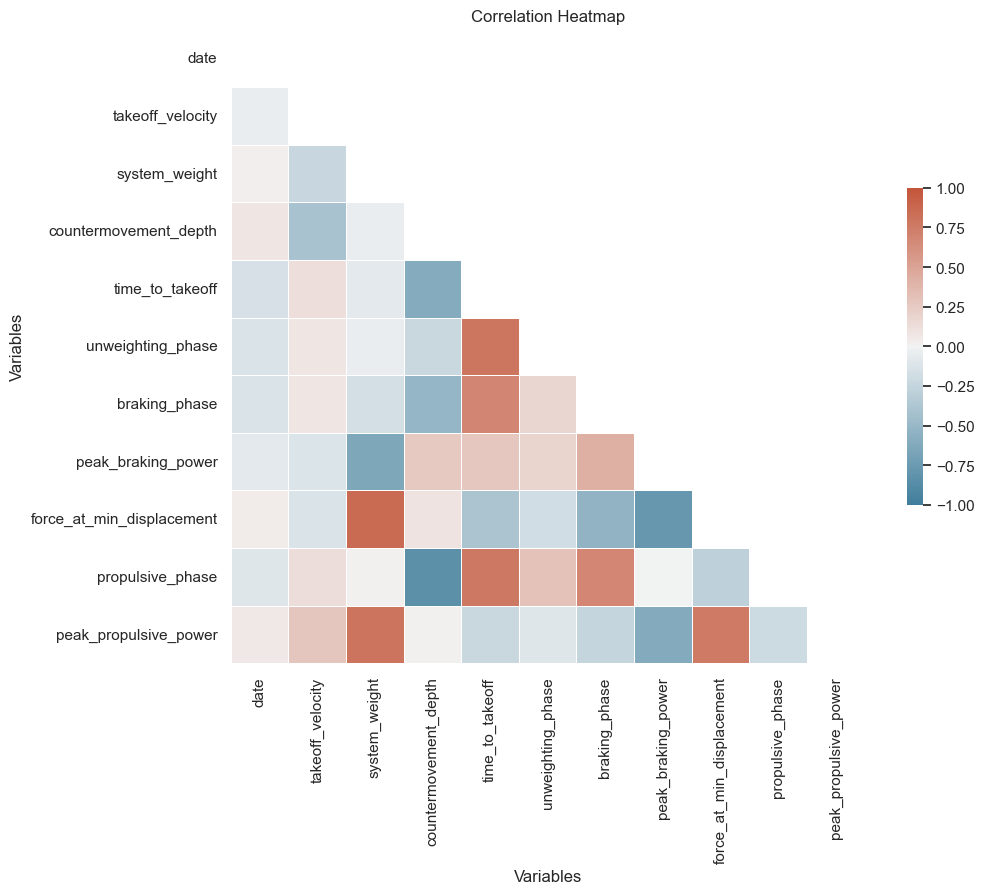

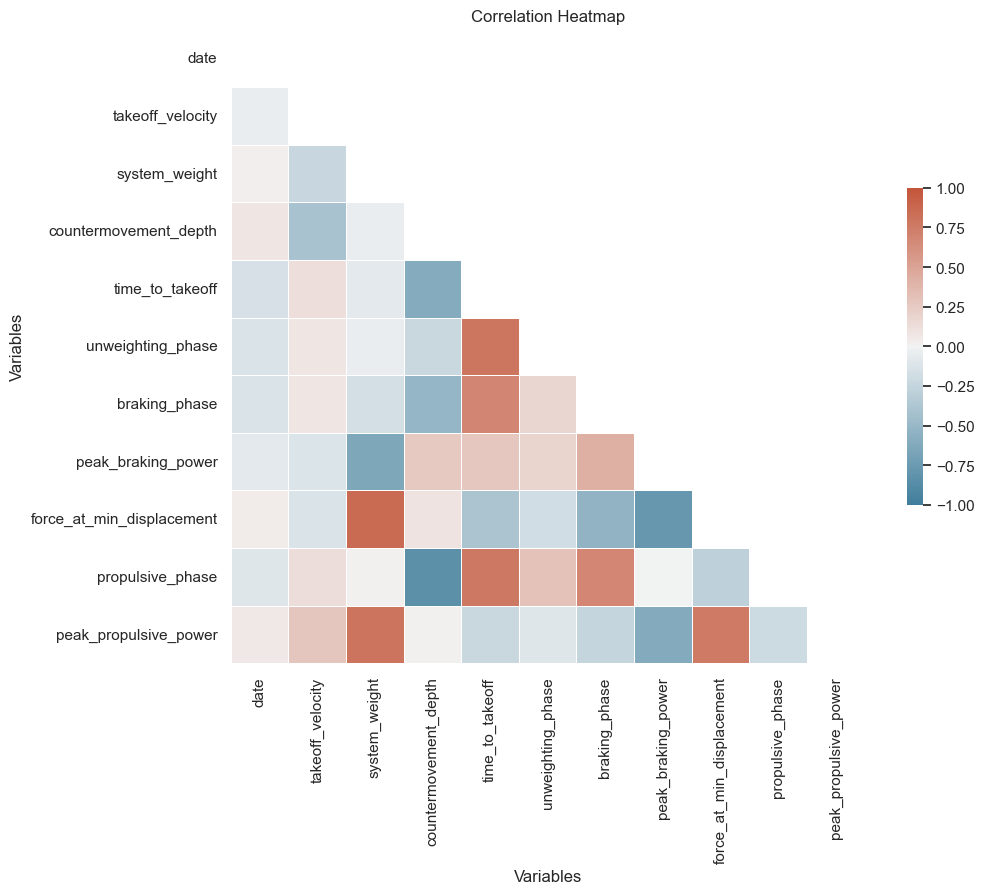

In [1062]:
correlation_plot(corr_df)

### P-Value

In [1063]:
pval_df = p_val_matrix(df.drop(['testid', 'date_str', 'time', 'name', 'position', ], axis=1))
pval_series_df = p_val_series(pval_df)
pval_series_df

,feature_1,feature_2,p_value
0,force_at_min_displacement,system_weight,4.499153e-156
1,propulsive_phase,countermovement_depth,6.960111e-145
2,peak_propulsive_power,system_weight,3.584966e-122
3,unweighting_phase,time_to_takeoff,2.111173e-118
4,propulsive_phase,time_to_takeoff,1.077522e-110
5,force_at_min_displacement,peak_braking_power,3.902754e-110
6,peak_propulsive_power,force_at_min_displacement,3.260445e-106
7,braking_phase,time_to_takeoff,1.090169e-79
8,propulsive_phase,braking_phase,1.756047e-76
9,peak_braking_power,system_weight,8.729056e-65


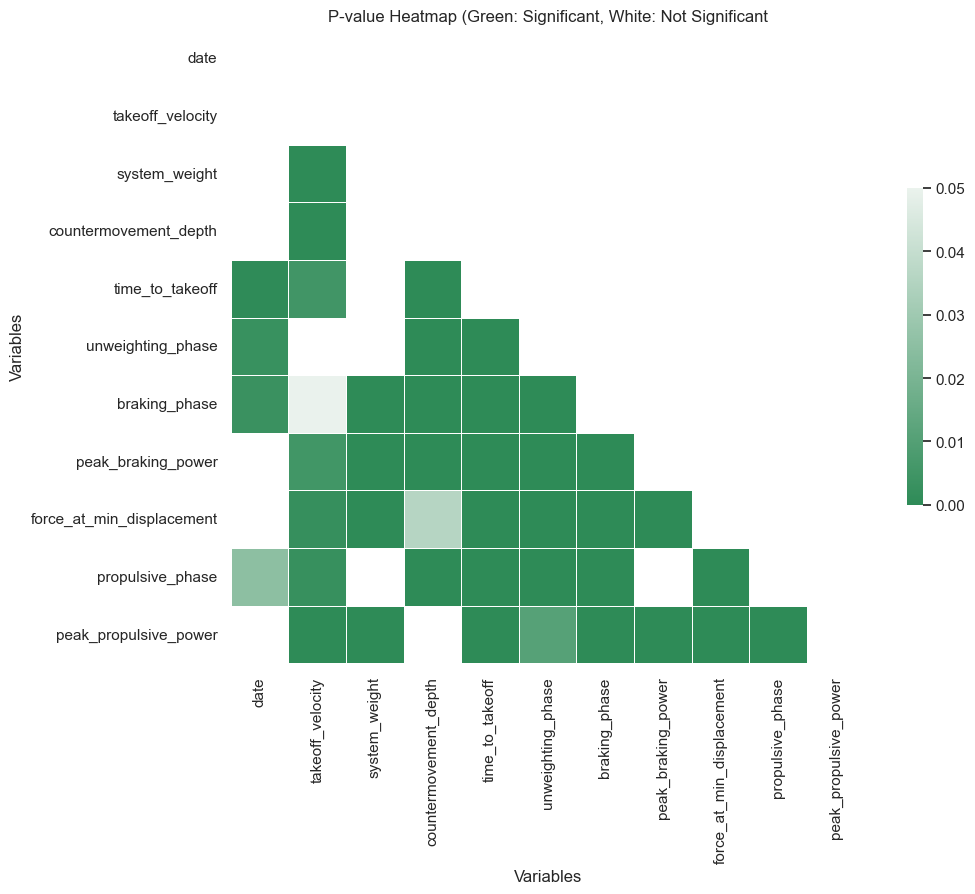

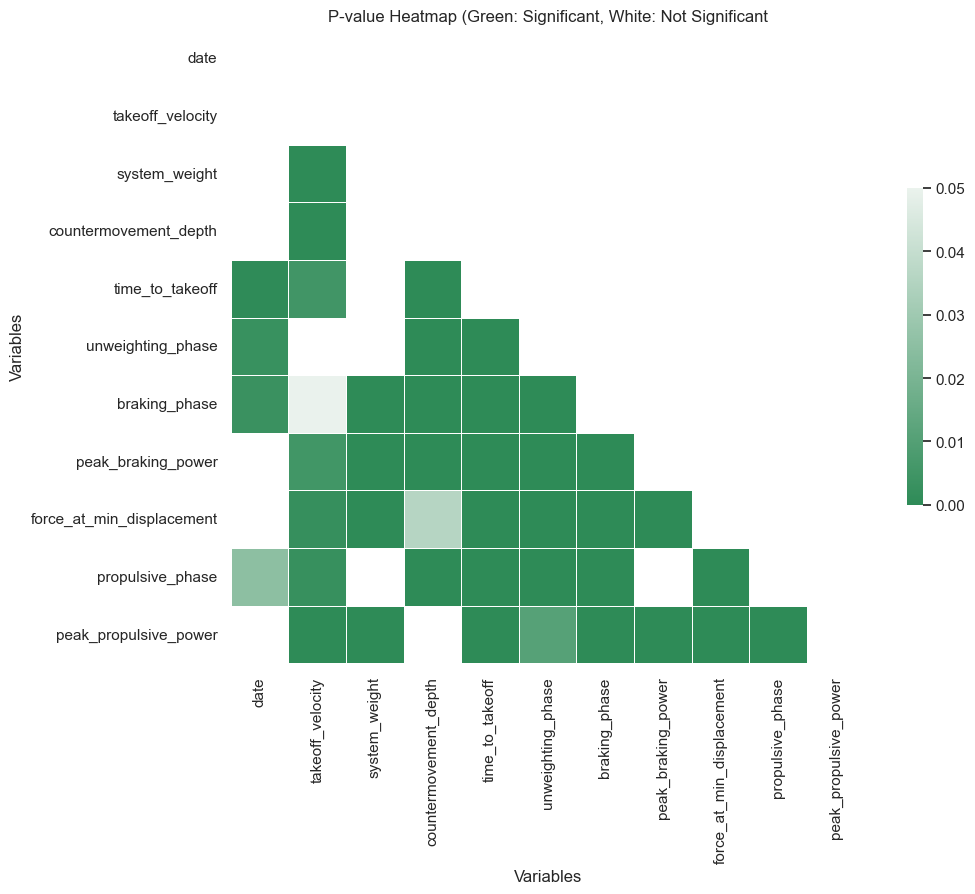

In [1064]:
p_val_plot(pval_df)

In [1065]:
corr_pval_series_merge_df = pd.merge(corr_series_df, pval_series_df, on = ['feature_1', 'feature_2'])
corr_pval_series_merge_df.to_csv(f'{project_data_exports_path}/corr_pval_series_merge_df.csv')
corr_pval_series_merge_df

,feature_1,feature_2,correlation_coefficient,p_value
0,force_at_min_displacement,system_weight,0.853053,4.499153e-156
1,peak_propulsive_power,system_weight,0.798413,3.584966e-122
2,unweighting_phase,time_to_takeoff,0.791038,2.111173e-118
3,propulsive_phase,time_to_takeoff,0.774973,1.077522e-110
4,peak_propulsive_power,force_at_min_displacement,0.764977,3.260445e-106
5,braking_phase,time_to_takeoff,0.693659,1.090169e-79
6,propulsive_phase,braking_phase,0.683330,1.756047e-76
7,peak_braking_power,braking_phase,0.426936,1.216876e-25
8,propulsive_phase,unweighting_phase,0.310576,1.072136e-13
9,peak_propulsive_power,takeoff_velocity,0.276204,4.918603e-11


In [1066]:
corr_pval_series_merge_df.sort_values(by=['p_value', 'correlation_coefficient'], ascending=[True, False]).reset_index(drop=True)


,feature_1,feature_2,correlation_coefficient,p_value
0,force_at_min_displacement,system_weight,0.853053,4.499153e-156
1,propulsive_phase,countermovement_depth,-0.837089,6.960111e-145
2,peak_propulsive_power,system_weight,0.798413,3.584966e-122
3,unweighting_phase,time_to_takeoff,0.791038,2.111173e-118
4,propulsive_phase,time_to_takeoff,0.774973,1.077522e-110
5,force_at_min_displacement,peak_braking_power,-0.773754,3.902754e-110
6,peak_propulsive_power,force_at_min_displacement,0.764977,3.260445e-106
7,braking_phase,time_to_takeoff,0.693659,1.090169e-79
8,propulsive_phase,braking_phase,0.683330,1.756047e-76
9,peak_braking_power,system_weight,-0.641638,8.729056e-65


## Jump Height Trends

In [1067]:
df.groupby('date_str').agg({'testid': 'count'})

,testid
date_str,
2022-03-22,18
2022-03-23,10
2022-03-24,20
2022-03-25,21
2022-03-26,12
2022-03-28,13
2022-03-29,21
2022-03-30,22
2022-03-31,2


In [1207]:
# Get the full range of dates
date_range = pd.date_range(start=df['date'].min(), end=df['date'].max())

# Get all unique positions
positions = df['position'].unique()

# Create a complete dataframe with all combinations of positions and date_str
complete_df = pd.MultiIndex.from_product([positions, date_range], names=['position', 'date']).to_frame(index=False)

# Merge with the original data to fill in the missing entries
complete_position_participation_df = pd.merge(
    complete_df,
    df.groupby(['position', 'date']).agg({'testid': 'count'}).reset_index(),
    on=['position', 'date'],
    how='left'
)

# Replace NaN values in 'testid' with 0 to indicate no observations
complete_position_participation_df['testid'] = complete_position_participation_df['testid'].fillna(0)

complete_position_participation_df

,position,date,testid
0,Sprints,2022-03-22,6.0
1,Sprints,2022-03-23,2.0
2,Sprints,2022-03-24,6.0
3,Sprints,2022-03-25,4.0
4,Sprints,2022-03-26,3.0
...,...,...,...
295,Unassigned,2022-05-06,0.0
296,Unassigned,2022-05-07,0.0
297,Unassigned,2022-05-08,0.0
298,Unassigned,2022-05-09,0.0


In [1203]:
position_participation_df = df.groupby(['position', 'date_str']).agg({'testid': 'count'}).reset_index()
position_participation_df

,position,date_str,testid
0,Distance,2022-03-22,2
1,Distance,2022-03-23,1
2,Distance,2022-03-24,2
3,Distance,2022-03-25,1
4,Distance,2022-03-29,1
...,...,...,...
147,Unassigned,2022-04-19,3
148,Unassigned,2022-04-21,2
149,Unassigned,2022-04-23,1
150,Unassigned,2022-04-25,2


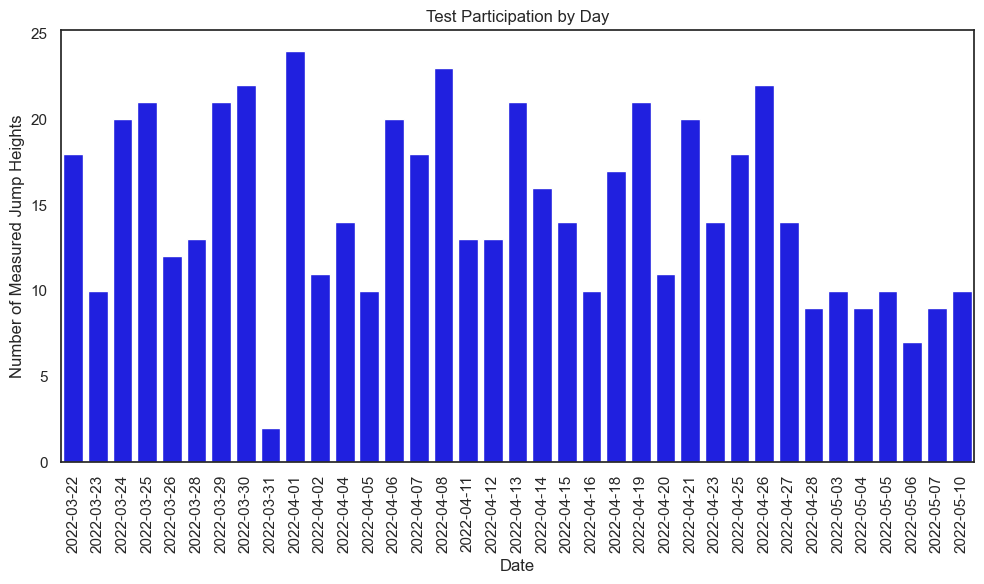

In [1213]:
measured_jump_counts_plot, ax = plt.subplots(1, 1, figsize=(10, 6))

sns.barplot(
    data=df.groupby('date_str').agg({'testid': 'count'}).reset_index(),
    x='date_str',
    y='testid',
    color='blue'
)
ax.set_title('Test Participation by Day')
ax.set_ylabel('Number of Measured Jump Heights')
ax.set_xlabel('Date')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
measured_jump_counts_plot.tight_layout()
measured_jump_counts_plot.savefig(f'{project_data_exports_path}/measured_jump_counts_plot.png', dpi=300,  bbox_inches='tight', pad_inches=0.5)

/Users/chrisizenour/opt/anaconda3/envs/msu/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



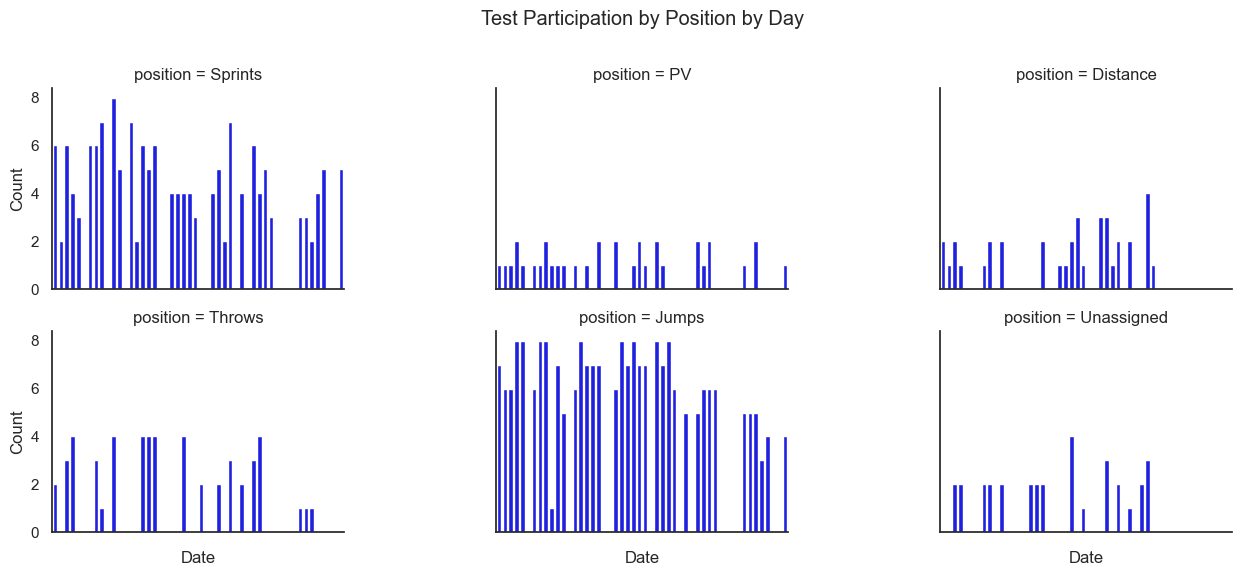

In [1215]:
measured_jump_counts_position_grid = sns.FacetGrid(complete_position_participation_df, col="position", col_wrap=3, height=3, aspect=1.5, sharex=True, sharey=True)
measured_jump_counts_position_grid.map_dataframe(sns.barplot, x="date", y="testid", color='blue')
measured_jump_counts_position_grid.set_xticklabels(labels=[])
measured_jump_counts_position_grid.set_axis_labels("Date", "Count")
# Adding a title for the entire figure
measured_jump_counts_position_grid.fig.suptitle(
    "Test Participation by Position by Day",
    # fontsize=16
)

# Adjust the position of the title and subplots for better layout
measured_jump_counts_position_grid.fig.subplots_adjust(top=0.85)

# To update the x-axis with a common label, we use FacetGrid's axes to set the label
for ax in measured_jump_counts_position_grid.axes:
    ax.set_xlabel('Date')
    ax.set_ylabel('Count')
measured_jump_counts_position_grid.savefig(f'{project_data_exports_path}/measured_jump_counts_position_grid.png', dpi=300,  bbox_inches='tight', pad_inches=0.5)

In [1069]:
# jump_height_box, ax = plt.subplots(1, 1, figsize=(10, 6), facecolor='white')
# 
# ax.set_ylim(0, 1)
# 
# sns.boxplot(
#     data=df,
#     x='date_str',
#     y='jump_height',
#     color='blue'
# )
# 
# jump_height_box_means = df.groupby('date_str')['jump_height'].mean().reset_index()
# 
# ax.plot(jump_height_box_means['date_str'], jump_height_box_means['jump_height'], color='red', marker='o', linestyle='-')
# 
# ax.set_title('Trend in Jump Height Distributions')
# ax.set_ylabel('Jump Height (m)')
# ax.set_xlabel('Date')
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# jump_height_box.tight_layout()
# jump_height_box.savefig(f'{project_data_exports_path}/jump_height_box.png', dpi=300,  bbox_inches='tight', pad_inches=0.5)

In [1070]:
# jump_height_box_means.min(), jump_height_box_means.max()

In [1071]:
# mean_jump_height_line, ax = plt.subplots(1, 1, figsize=(10, 6), facecolor='white')
# 
# sns.lineplot(
#     data=df.groupby('date_str').agg({'jump_height': 'mean'}).reset_index(),
#     x='date_str',
#     y='jump_height',
#     color='blue',
#     errorbar='se'
# )
# ax.set_title('Trend in Daily Average Jump Height Distributions')
# ax.set_ylabel('Jump Height (m)')
# ax.set_xlabel('Date')
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# mean_jump_height_line.tight_layout()

In [1072]:
# daily_jump_height_mean_df = df.groupby('date_str').agg({'jump_height': 'mean'})
# daily_jump_height_mean_norm_df = daily_jump_height_mean_df.div(daily_jump_height_mean_df.iloc[0]).mul(100).reset_index()
# daily_jump_height_mean_norm_df.columns = ['date_str', 'normalized_jump_height']
# daily_jump_height_mean_norm_df

In [1073]:
# jump_height_norm_line, ax = plt.subplots(1, 1, figsize=(10, 6), facecolor='white')
# 
# sns.lineplot(
#     data=daily_jump_height_mean_norm_df,
#     x='date_str',
#     y='normalized_jump_height',
#     color='blue',
#     errorbar='se'
# )
# ax.set_title('Normalized Daily Mean Jump Height')
# ax.set_ylabel('Normalized Jump Height (Base = 100 on Day 1)')
# ax.set_xlabel('Date')
# ax.axhline(y=100, color='gray', linestyle='--')
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# jump_height_norm_line.tight_layout()

In [1074]:
# jump_height_takeoff_velocity_scatter, ax = plt.subplots(1, 1, figsize=(10,6), facecolor='white')
# 
# # ax.set_ylim(0, 1)
# # ax.set_xlim(0, 4)
# 
# sns.scatterplot(
#     data=df,
#     x='takeoff_velocity',
#     y='jump_height',
#     # hue='position'
# )
# 
# ax.set_title('Jump Height (m) vs Takeoff Velocity (m/s)')
# ax.set_xlabel('Takeoff Velocity (m/s)')
# ax.set_ylabel('Jump Height (m)')
# jump_height_takeoff_velocity_scatter.tight_layout()
# jump_height_takeoff_velocity_scatter.savefig(f'{project_data_exports_path}/jump_height_takeoff_velocity_scatter.png', dpi=300, bbox_inches='tight', pad_inches=0.5)

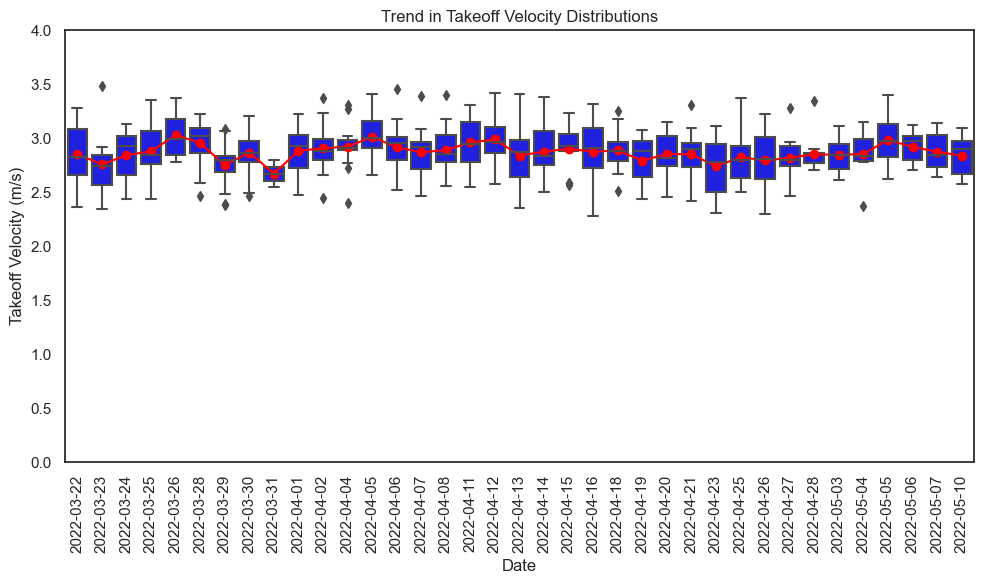

In [1075]:
takeoff_velocity_box, ax = plt.subplots(1, 1, figsize=(10, 6), facecolor='white')

ax.set_ylim(0, 4)

sns.boxplot(
    data=df,
    x='date_str',
    y='takeoff_velocity',
    color='blue'
)

takeoff_velocity_box_means = df.groupby('date_str')['takeoff_velocity'].mean().reset_index()

ax.plot(takeoff_velocity_box_means['date_str'], takeoff_velocity_box_means['takeoff_velocity'], color='red', marker='o', linestyle='-')

ax.set_title('Trend in Takeoff Velocity Distributions')
ax.set_ylabel('Takeoff Velocity (m/s)')
ax.set_xlabel('Date')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
takeoff_velocity_box.tight_layout()
takeoff_velocity_box.savefig(f'{project_data_exports_path}/takeoff_velocity_box.png', dpi=300,  bbox_inches='tight', pad_inches=0.5)

In [1076]:
takeoff_velocity_box_means.min(), takeoff_velocity_box_means.max()

(date_str            2022-03-22
 takeoff_velocity        2.6732
 dtype: object,
 date_str            2022-05-10
 takeoff_velocity      3.029533
 dtype: object)

/var/folders/kk/54xn9lv90wq5vmw11pj1svvr0000gn/T/ipykernel_39205/3231928787.py:13: UserWarning:

FixedFormatter should only be used together with FixedLocator



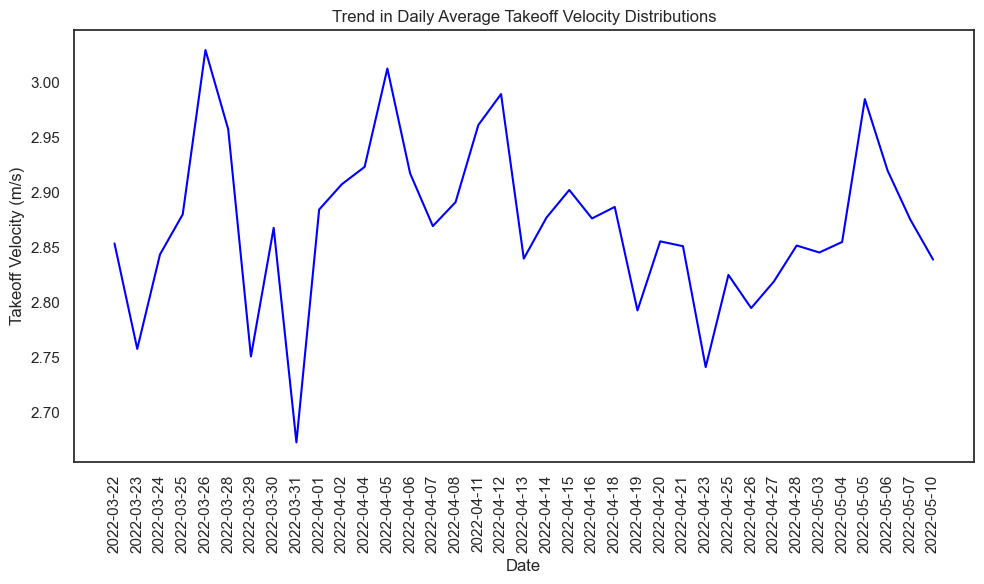

In [1077]:
mean_takeoff_velocity_line, ax = plt.subplots(1, 1, figsize=(10, 6), facecolor='white')

sns.lineplot(
    data=df.groupby('date_str').agg({'takeoff_velocity': 'mean'}).reset_index(),
    x='date_str',
    y='takeoff_velocity',
    color='blue',
    errorbar='se'
)
ax.set_title('Trend in Daily Average Takeoff Velocity Distributions')
ax.set_ylabel('Takeoff Velocity (m/s)')
ax.set_xlabel('Date')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
mean_takeoff_velocity_line.tight_layout()

In [1078]:
daily_takeoff_velocity_mean_df = df.groupby('date_str').agg({'takeoff_velocity': 'mean'})
daily_takeoff_velocity_mean_norm_df = daily_takeoff_velocity_mean_df.div(daily_takeoff_velocity_mean_df.iloc[0]).mul(100).reset_index()
daily_takeoff_velocity_mean_norm_df.columns = ['date_str', 'normalized_takeoff_velocity']
daily_takeoff_velocity_mean_norm_df

,date_str,normalized_takeoff_velocity
0,2022-03-22,100.000000
1,2022-03-23,96.645558
2,2022-03-24,99.649208
3,2022-03-25,100.925925
4,2022-03-26,106.155598
5,2022-03-28,103.636384
6,2022-03-29,96.405065
7,2022-03-30,100.495749
8,2022-03-31,93.669590
9,2022-04-01,101.079434


/var/folders/kk/54xn9lv90wq5vmw11pj1svvr0000gn/T/ipykernel_39205/3937510467.py:14: UserWarning:

FixedFormatter should only be used together with FixedLocator



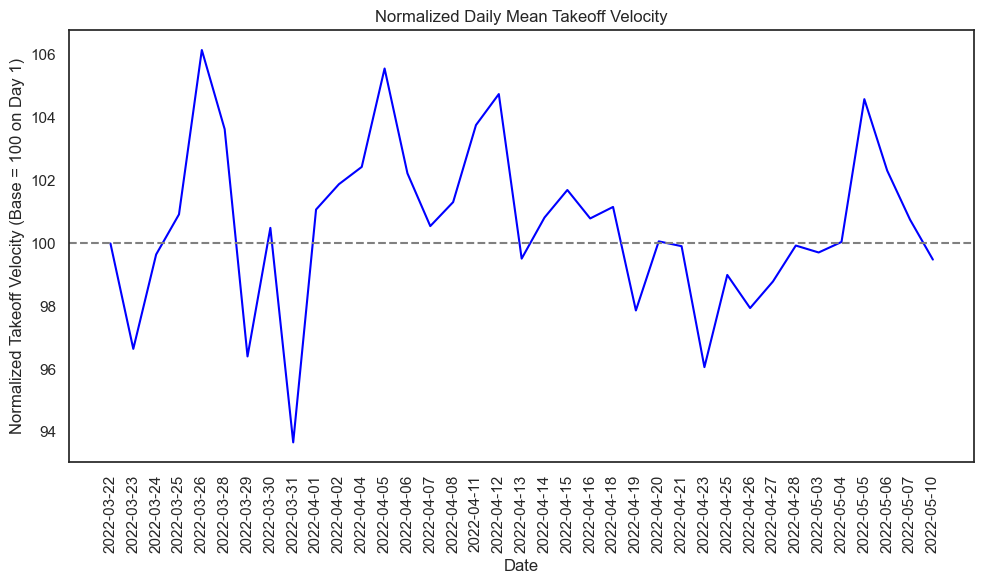

In [1079]:
takeoff_velocity_norm_line, ax = plt.subplots(1, 1, figsize=(10, 6), facecolor='white')

sns.lineplot(
    data=daily_takeoff_velocity_mean_norm_df,
    x='date_str',
    y='normalized_takeoff_velocity',
    color='blue',
    errorbar='se'
)
ax.set_title('Normalized Daily Mean Takeoff Velocity')
ax.set_ylabel('Normalized Takeoff Velocity (Base = 100 on Day 1)')
ax.set_xlabel('Date')
ax.axhline(y=100, color='gray', linestyle='--')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
takeoff_velocity_norm_line.tight_layout()

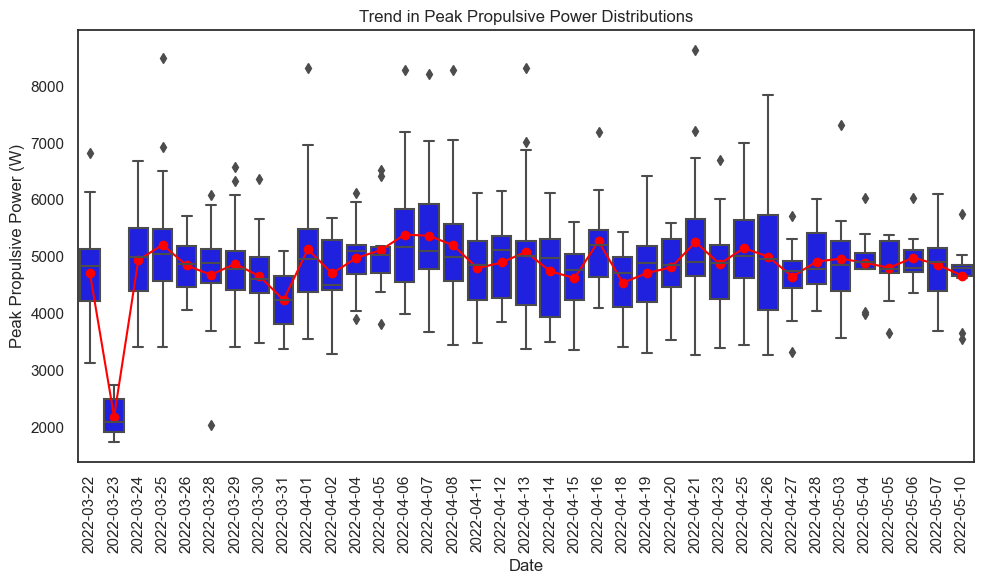

In [1133]:
peak_propulsive_power_box, ax = plt.subplots(1, 1, figsize=(10, 6), facecolor='white')

# ax.set_ylim(0, 4)

sns.boxplot(
    data=df,
    x='date_str',
    y='peak_propulsive_power',
    color='blue'
)

peak_propulsive_power_box_means = df.groupby('date_str')['peak_propulsive_power'].mean().reset_index()

ax.plot(peak_propulsive_power_box_means['date_str'], peak_propulsive_power_box_means['peak_propulsive_power'], color='red', marker='o', linestyle='-')

ax.set_title('Trend in Peak Propulsive Power Distributions')
ax.set_ylabel('Peak Propulsive Power (W)')
ax.set_xlabel('Date')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
peak_propulsive_power_box.tight_layout()
peak_propulsive_power_box.savefig(f'{project_data_exports_path}/peak_propulsive_power_box.png', dpi=300,  bbox_inches='tight', pad_inches=0.5)

In [1134]:
peak_propulsive_power_box_means.min(), peak_propulsive_power_box_means.max()

(date_str                 2022-03-22
 peak_propulsive_power    2181.25704
 dtype: object,
 date_str                  2022-05-10
 peak_propulsive_power    5388.592595
 dtype: object)

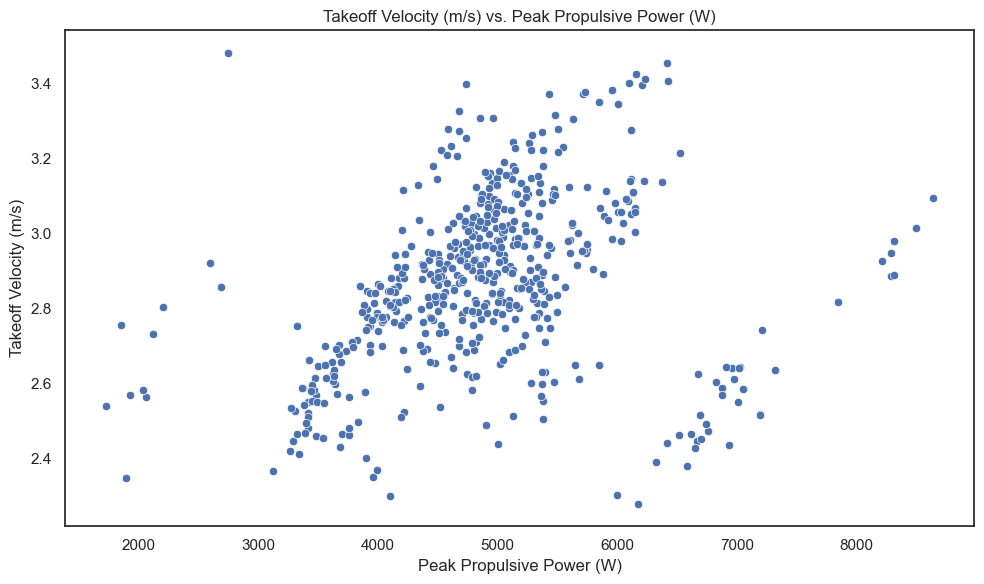

In [1135]:
takeoff_velocity_peak_propul_power_scatter, ax = plt.subplots(1, 1, figsize=(10,6), facecolor='white')

# ax.set_ylim(0, 1)
# ax.set_xlim(0, 4)

sns.scatterplot(
    data=df,
    x='peak_propulsive_power',
    y='takeoff_velocity',
    # hue='position'
)

ax.set_title('Takeoff Velocity (m/s) vs. Peak Propulsive Power (W)')
ax.set_xlabel('Peak Propulsive Power (W)')
ax.set_ylabel('Takeoff Velocity (m/s)')
takeoff_velocity_peak_propul_power_scatter.tight_layout()
takeoff_velocity_peak_propul_power_scatter.savefig(f'{project_data_exports_path}/takeoff_velocity_peak_propul_power_scatter.png', dpi=300, bbox_inches='tight', pad_inches=0.5)

In [1196]:
daily_avg_takeoff_velocity = df.groupby(['date', 'position'])['takeoff_velocity'].mean().reset_index()
daily_avg_takeoff_velocity.to_csv(f'{project_data_exports_path}/daily_avg_takeoff_velocity.csv')
daily_avg_takeoff_velocity

,date,position,takeoff_velocity
0,2022-03-22,Distance,2.684300
1,2022-03-22,Jumps,2.910943
2,2022-03-22,PV,2.688800
3,2022-03-22,Sprints,2.909967
4,2022-03-22,Throws,2.737850
...,...,...,...
147,2022-05-07,Jumps,2.887450
148,2022-05-07,Sprints,2.865960
149,2022-05-10,Jumps,2.796725
150,2022-05-10,PV,2.649600


/Users/chrisizenour/opt/anaconda3/envs/msu/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



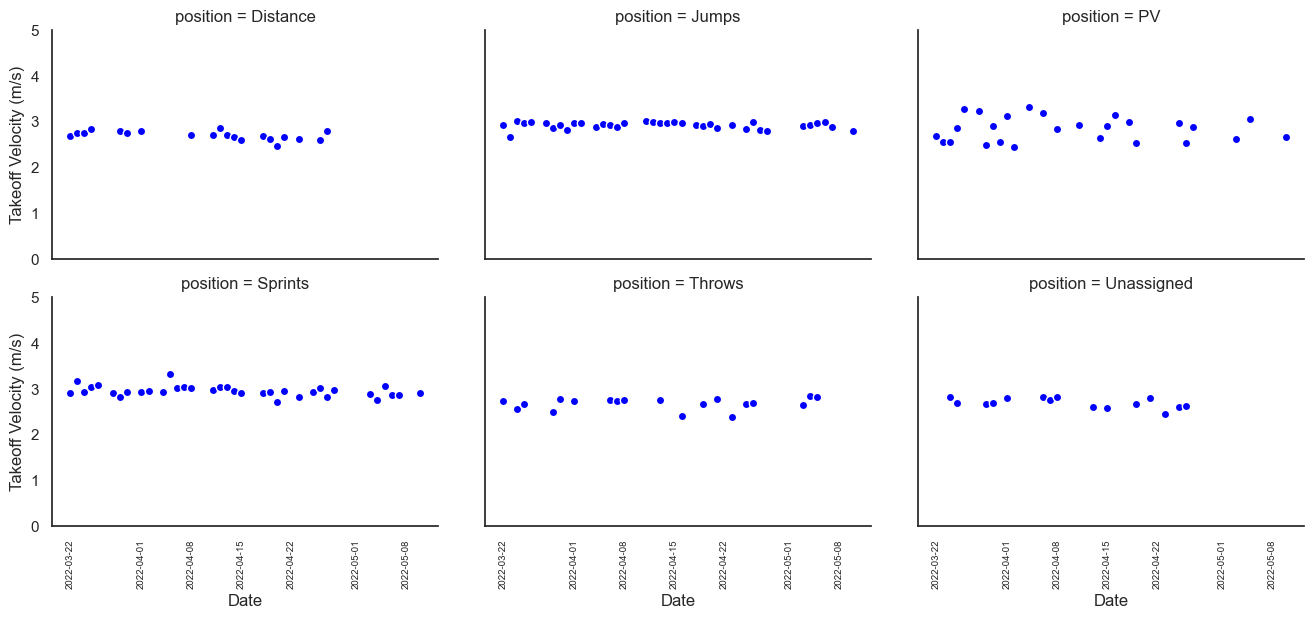

In [1202]:
position_takeoff_velocity_relplot = sns.relplot(
    daily_avg_takeoff_velocity,
    x='date',
    y='takeoff_velocity',
    col='position',
    kind='scatter',
    col_wrap=3,
    color='blue',
    facet_kws={'sharex': True, 'sharey': True},
    height=3,
    aspect=1.5,
    linewidth=1
)

for ax in position_takeoff_velocity_relplot.axes.flat:
    ax.tick_params(axis='x', rotation=90, labelsize='xx-small')
    ax.set_ylim(bottom=0)
    ax.set_ylim(top=5)
position_takeoff_velocity_relplot.set_xlabels('Date')
position_takeoff_velocity_relplot.set_ylabels('Takeoff Velocity (m/s)')
position_takeoff_velocity_relplot.savefig(f'{project_data_exports_path}/position_takeoff_velocity_relplot.png', dpi=300, bbox_inches='tight', pad_inches=0.5)

In [1153]:
daily_avg_peak_propul_power = df.groupby(['date_str', 'position'])['peak_propulsive_power'].mean().reset_index()
daily_avg_peak_propul_power.to_csv(f'{project_data_exports_path}/daily_avg_peak_propul_power.csv')
daily_avg_peak_propul_power

,date_str,position,peak_propulsive_power
0,2022-03-22,Distance,3397.437650
1,2022-03-22,Jumps,4744.175514
2,2022-03-22,PV,3730.744500
3,2022-03-22,Sprints,4840.460000
4,2022-03-22,Throws,6049.138750
...,...,...,...
147,2022-05-07,Jumps,4653.809300
148,2022-05-07,Sprints,5018.266560
149,2022-05-10,Jumps,4496.460900
150,2022-05-10,PV,3558.184700


In [1180]:
daily_avg_peak_propul_power2 = df.groupby(['date', 'position'])['peak_propulsive_power'].mean().reset_index()
daily_avg_peak_propul_power2.to_csv(f'{project_data_exports_path}/daily_avg_peak_propul_power2.csv')
daily_avg_peak_propul_power2

,date,position,peak_propulsive_power
0,2022-03-22,Distance,3397.437650
1,2022-03-22,Jumps,4744.175514
2,2022-03-22,PV,3730.744500
3,2022-03-22,Sprints,4840.460000
4,2022-03-22,Throws,6049.138750
...,...,...,...
147,2022-05-07,Jumps,4653.809300
148,2022-05-07,Sprints,5018.266560
149,2022-05-10,Jumps,4496.460900
150,2022-05-10,PV,3558.184700


In [1154]:
pivot_daily_avg_peak_propul_power_df = daily_avg_peak_propul_power.pivot(index='date_str', columns='position', values='peak_propulsive_power')
pivot_daily_avg_peak_propul_power_df

position,Distance,Jumps,PV,Sprints,Throws,Unassigned
date_str,,,,,,
2022-03-22,3397.437650,4744.175514,3730.74450,4840.460000,6049.138750,NaN
2022-03-23,1853.490800,2133.471533,1730.09990,2714.075250,NaN,NaN
2022-03-24,3762.314950,4743.424317,3416.76740,4978.944383,6249.940933,5388.041400
2022-03-25,3935.389900,4718.797437,4039.12740,5510.397600,6846.784825,5087.609000
2022-03-26,NaN,4699.387575,4674.28840,5287.120500,NaN,NaN
2022-03-28,NaN,4383.532000,4528.39380,5001.415033,NaN,NaN
2022-03-29,3907.535300,4679.328875,3415.43230,4986.560717,6001.008833,4838.511450
2022-03-30,3819.936100,4653.793687,4032.73320,4987.513000,5147.336600,4700.329800
2022-03-31,NaN,5093.871400,3381.93260,NaN,NaN,NaN


/var/folders/kk/54xn9lv90wq5vmw11pj1svvr0000gn/T/ipykernel_39205/1764890465.py:14: UserWarning:

FixedFormatter should only be used together with FixedLocator



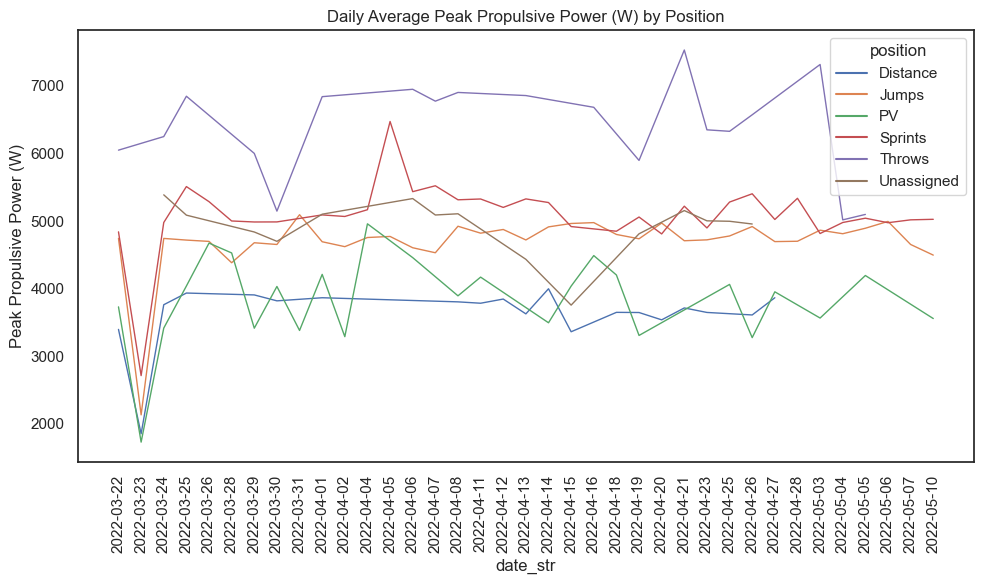

In [1166]:
position_peak_propul_power_line, ax = plt.subplots(1, 1, figsize=(10, 6), facecolor='white')

sns.lineplot(
    pivot_daily_avg_peak_propul_power_df,
    linewidth=1,
    dashes=False,
    ax=ax
    # marker='o'
)

ax.set_title('Daily Average Peak Propulsive Power (W) by Position')
ax.set_xlabel('Date')
ax.set_ylabel('Peak Propulsive Power (W)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
position_peak_propul_power_line.tight_layout()





/Users/chrisizenour/opt/anaconda3/envs/msu/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



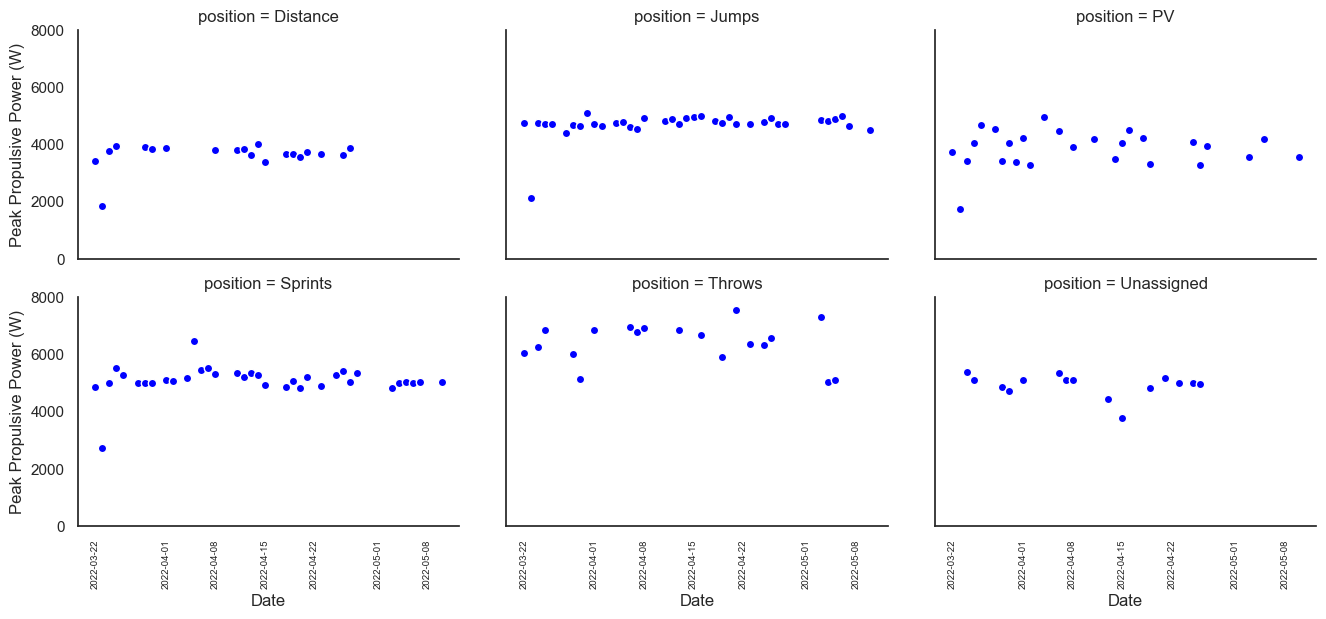

In [1201]:
position_peak_propul_power_relplot = sns.relplot(
    daily_avg_peak_propul_power2,
    x='date',
    y='peak_propulsive_power',
    col='position',
    kind='scatter',
    col_wrap=3,
    color='blue',
    facet_kws={'sharex': True, 'sharey': True},
    height=3,
    aspect=1.5,
    linewidth=1
)

for ax in position_peak_propul_power_relplot.axes.flat:
    ax.tick_params(axis='x', rotation=90, labelsize='xx-small')
    ax.set_ylim(bottom=0)
    ax.set_ylim(top=8000)
position_peak_propul_power_relplot.set_xlabels('Date')
position_peak_propul_power_relplot.set_ylabels('Peak Propulsive Power (W)')
position_peak_propul_power_relplot.savefig(f'{project_data_exports_path}/position_peak_propul_power_relplot.png', dpi=300, bbox_inches='tight', pad_inches=0.5)



/Users/chrisizenour/opt/anaconda3/envs/msu/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



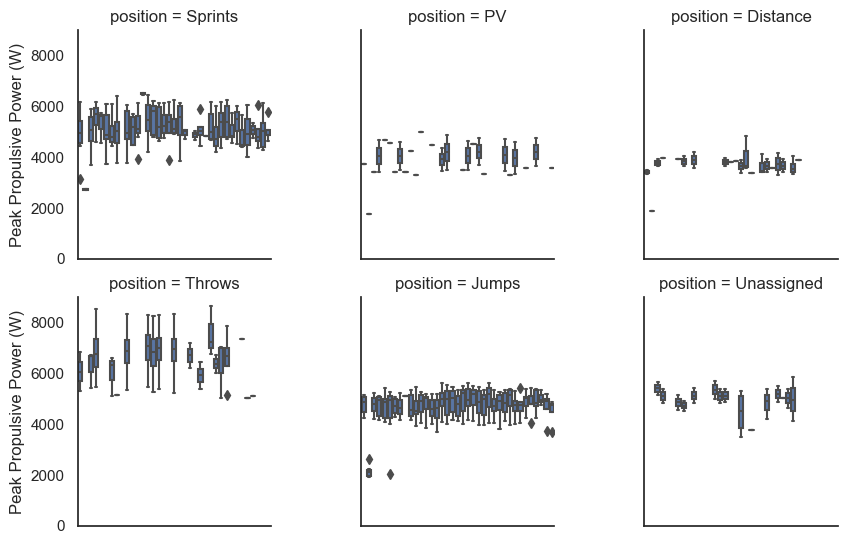

In [1195]:
position_peak_propul_power_facet = sns.FacetGrid(
    data=df,
    col='position',
    col_wrap=3,
    sharex=True,
    sharey=True,
    # height=2,
    # aspect=1.5
)
position_peak_propul_power_facet.map(sns.boxplot,
                                     'date_str',
                                     'peak_propulsive_power',
                                     order=sorted(df['date_str'].unique()))

for ax in position_peak_propul_power_facet.axes.flatten():
    ax.set_xticklabels([])
    ax.set_xlabel('')
    ax.set_ylabel('Peak Propulsive Power (W)')
    ax.set_ylim(bottom=0)

# position_peak_propul_power_facet.tight_layout()

## Statistical Tests

In [1080]:
unique_positions = df['position'].unique()
unique_positions

array(['Sprints', 'PV', 'Distance', 'Throws', 'Jumps', 'Unassigned'],
      dtype=object)

In [1081]:
p_values = []
comparisons = []
for i in range(len(unique_positions)):
    for j in range(i+1, len(unique_positions)):
        pos1 = unique_positions[i]
        pos2 = unique_positions[j]
        
        jump_height_pos1 = df[df['position'] == pos1]['takeoff_velocity']
        jump_height_pos2 = df[df['position'] == pos2]['takeoff_velocity']
        
        t_stat, p_value = stats.ttest_ind(jump_height_pos1, jump_height_pos2, nan_policy='omit')
        
        # Store the result
        comparisons.append(f"{pos1} vs {pos2}")
        p_values.append(p_value)

# Apply Bonferroni correction
bonf_corrected = multipletests(p_values, method='bonferroni')

# Apply Holm's method
holm_corrected = multipletests(p_values, method='holm')

# Create a DataFrame to show the results
results_df = pd.DataFrame({
    'Comparison': comparisons,
    'P-Value': p_values,
    'Bonferroni Corrected': bonf_corrected[1],
    'Holm Corrected': holm_corrected[1]
}).sort_values(by='P-Value', ascending=True).reset_index(drop=True)

results_df.to_csv(f'{project_data_exports_path}/results_df.csv')
results_df

,Comparison,P-Value,Bonferroni Corrected,Holm Corrected
0,Throws vs Jumps,2.903558e-18,4.355337e-17,4.355337e-17
1,Distance vs Jumps,8.352826e-15,1.252924e-13,1.169396e-13
2,Sprints vs Throws,2.020421e-12,3.030631e-11,2.626547e-11
3,Jumps vs Unassigned,2.883799e-12,4.325698e-11,3.460558e-11
4,Sprints vs Distance,7.092312e-10,1.063847e-08,7.801543e-09
5,Sprints vs Unassigned,2.403532e-08,3.605299e-07,2.403532e-07
6,PV vs Throws,2.294633e-03,3.441949e-02,2.065170e-02
7,PV vs Distance,6.250289e-03,9.375434e-02,5.000231e-02
8,PV vs Unassigned,1.649257e-02,2.473886e-01,1.154480e-01
9,PV vs Jumps,8.158647e-02,1.000000e+00,4.895188e-01


# Clustering

In [1082]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 547 entries, 0 to 546
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   testid                     547 non-null    object        
 1   date                       547 non-null    datetime64[ns]
 2   date_str                   547 non-null    object        
 3   time                       547 non-null    object        
 4   name                       547 non-null    object        
 5   position                   547 non-null    object        
 6   takeoff_velocity           547 non-null    float64       
 7   system_weight              547 non-null    float64       
 8   countermovement_depth      547 non-null    float64       
 9   time_to_takeoff            547 non-null    float64       
 10  unweighting_phase          547 non-null    float64       
 11  braking_phase              547 non-null    float64       
 12  peak_bra

In [1083]:
clustering_df = df.copy()
clustering_df = clustering_df.iloc[:, 7:]
clustering_df
# clustering_df

,system_weight,countermovement_depth,time_to_takeoff,unweighting_phase,braking_phase,peak_braking_power,force_at_min_displacement,propulsive_phase,peak_propulsive_power
0,723.7908,-0.3716,1.086,0.588,0.238,-657.1589,1530,0.260,5509.0807
1,668.6937,-0.2793,0.673,0.315,0.132,-1391.1700,1843,0.226,4438.9458
2,711.4374,-0.3135,0.916,0.396,0.195,-792.5835,1395,0.325,3730.7445
3,744.8048,-0.4278,0.909,0.386,0.244,-1049.4055,1735,0.279,4820.3112
4,724.2543,-0.4430,1.005,0.399,0.244,-1145.4309,1373,0.362,3472.5154
...,...,...,...,...,...,...,...,...,...
542,770.9199,-0.2398,0.712,0.344,0.159,-1082.5908,1667,0.209,4846.5209
543,888.7668,-0.3474,0.697,0.327,0.134,-2664.2897,2413,0.236,5748.4795
544,749.5766,-0.2507,0.724,0.372,0.147,-1411.2698,1860,0.205,4858.5551
545,720.0120,-0.4150,0.724,0.302,0.196,-1675.3063,1714,0.226,4747.4210


In [1084]:
clustering_df.isnull().sum()

system_weight                0
countermovement_depth        0
time_to_takeoff              0
unweighting_phase            0
braking_phase                0
peak_braking_power           0
force_at_min_displacement    0
propulsive_phase             0
peak_propulsive_power        0
dtype: int64

In [1085]:
inertias_df = inertia_scores(clustering_df)
inertias_df

[4923.0,
 3434.935407029723,
 2568.1782549985473,
 2219.995897953388,
 1940.7479948390933,
 1792.739009092934,
 1655.0233686716724,
 1546.4832556147835,
 1448.0818637628681,
 1371.2241095711943,
 1313.9983297598437,
 1246.4847067624073,
 1211.3628047790262,
 1147.2102566059075,
 1105.143111227129]

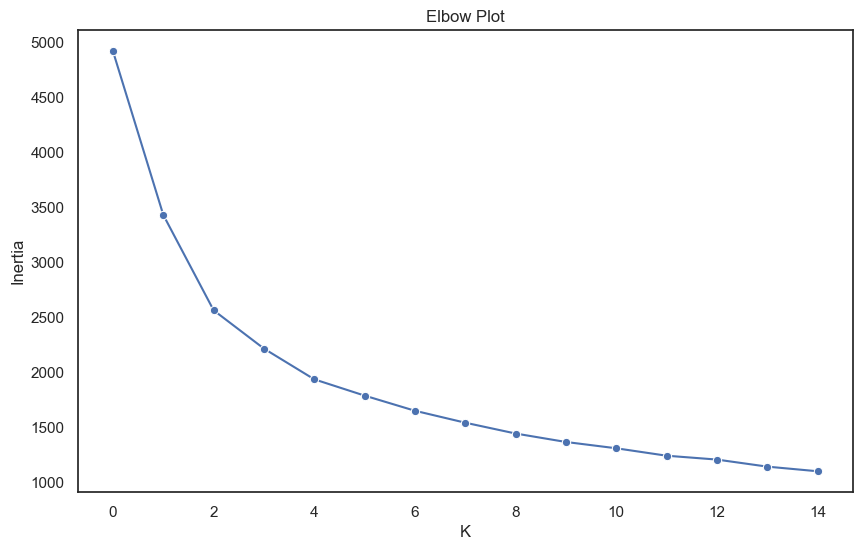

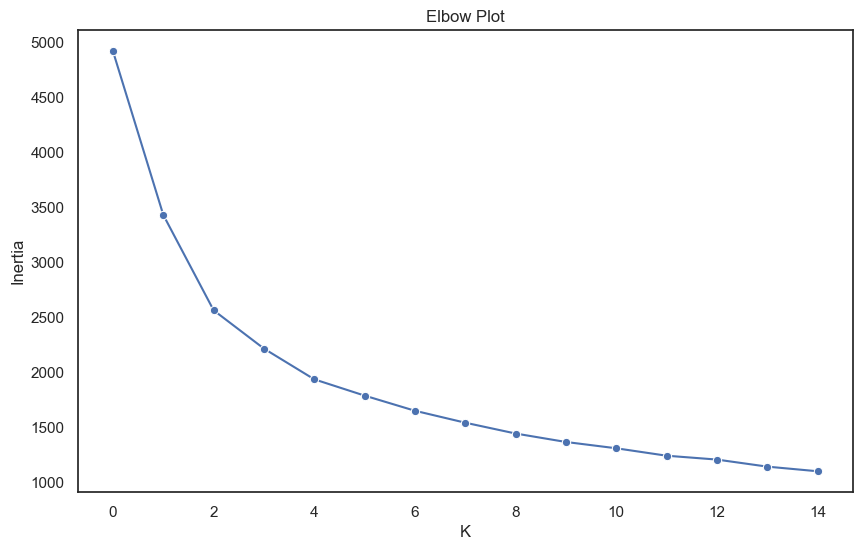

In [1086]:
elbow_plot(inertias_df)

In [1087]:
silhouettes_df = silhouette_scores(clustering_df)
silhouettes_df

/Users/chrisizenour/opt/anaconda3/envs/msu/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/chrisizenour/opt/anaconda3/envs/msu/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/chrisizenour/opt/anaconda3/envs/msu/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/chrisizenour/opt/anaconda3/envs/msu/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



,silhouette_score,k
0,0.196987,2
1,0.088527,3
2,0.063080,4
3,0.051609,5
4,0.074506,6
5,0.048297,7
6,0.030169,8
7,0.002834,9
8,-0.010492,10
9,-0.013296,11


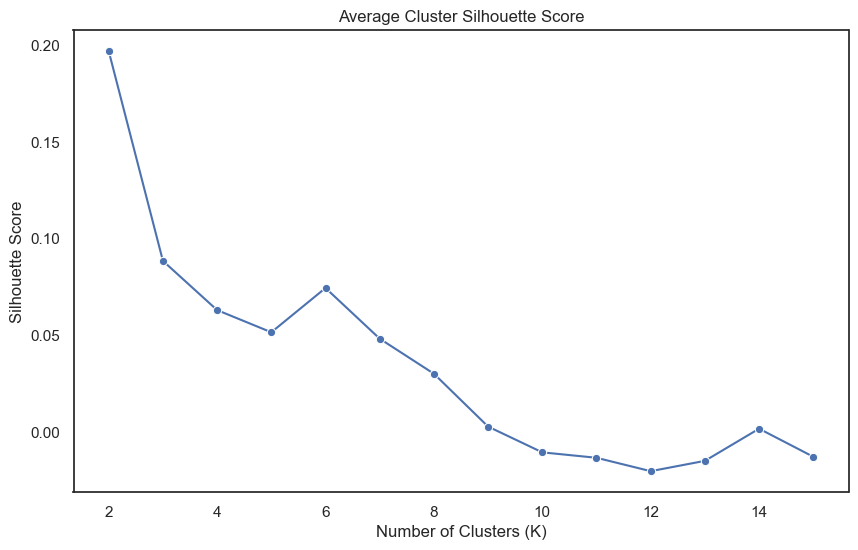

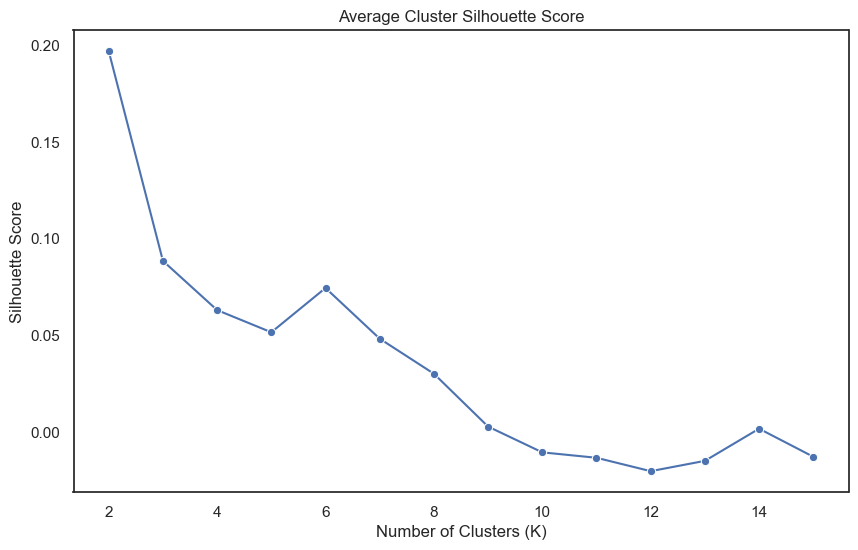

In [1088]:
silhouette_score_plot(silhouettes_df)

In [1089]:
pca_exp_var_df = pca_cumsum_exp_var_ratios(clustering_df)
pca_exp_var_df


,principal_component_qty,feature_explained_variance,feature_cumsum_explained_variance
0,0,0.450202,0.450202
1,1,0.297695,0.747897
2,2,0.118311,0.866208
3,3,0.076481,0.942688
4,4,0.02948,0.972169
5,5,0.012785,0.984953
6,6,0.0116,0.996553
7,7,0.003447,1.0
8,8,0.0,1.0


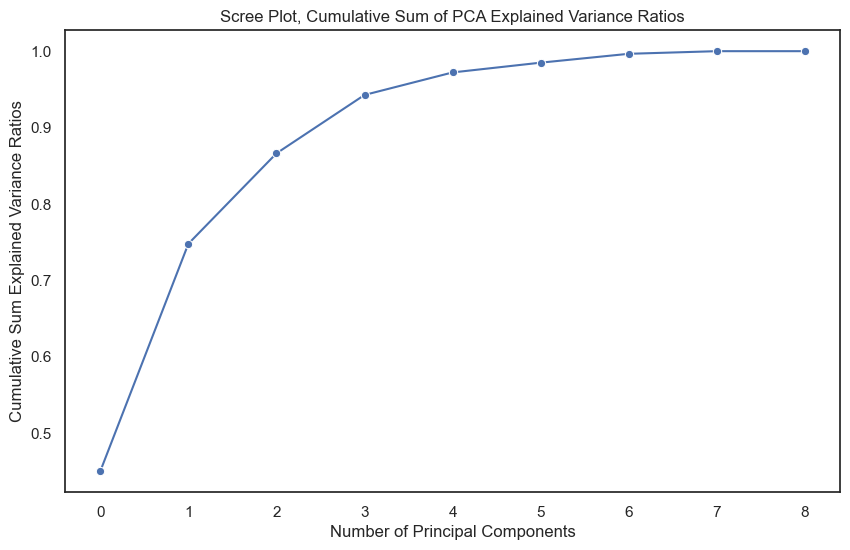

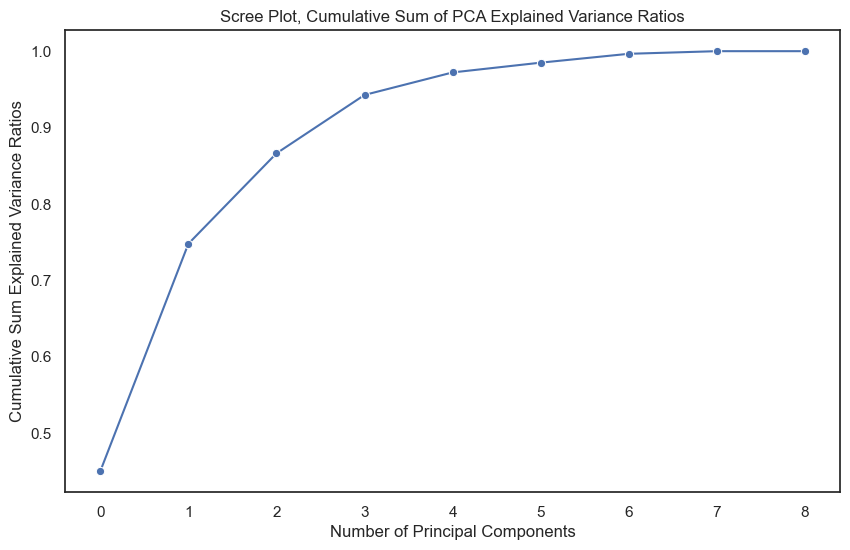

In [1090]:
scree_plot(pca_exp_var_df)

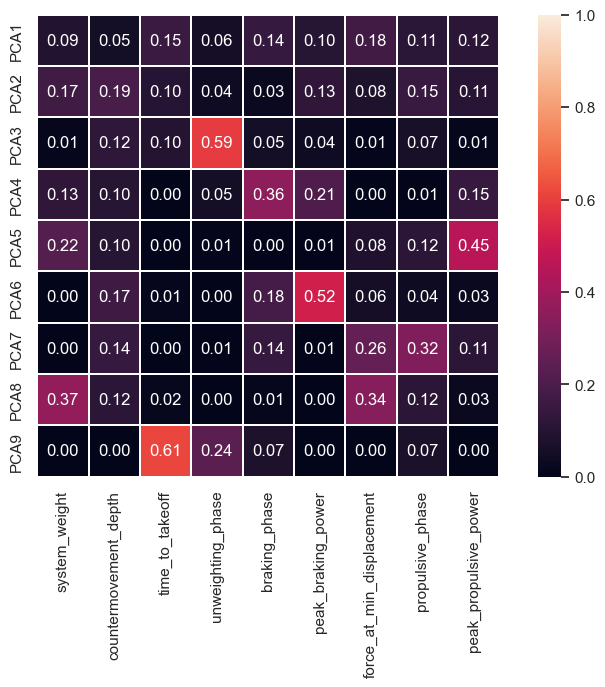

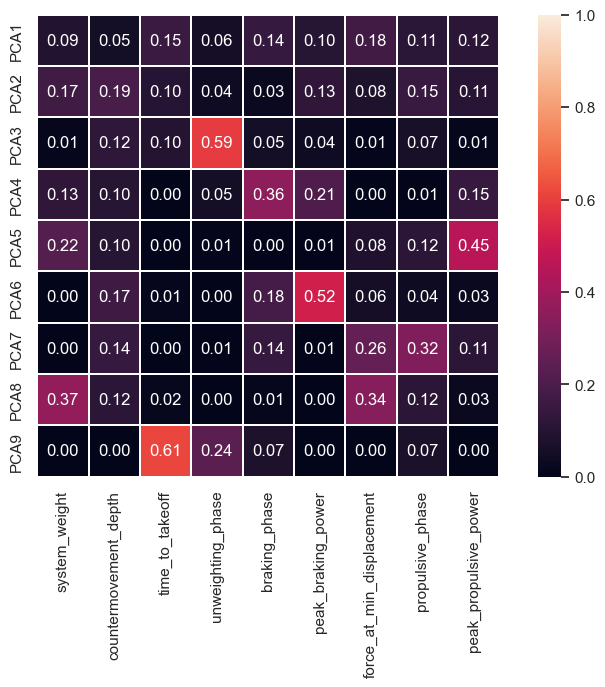

In [1091]:
pca_matrix_heatmap(clustering_df)

In [1092]:
pca_cluster_df, centroids_x, centroids_y = pca_cluster_df(clustering_df, 2, 6)
pca_cluster_df

/Users/chrisizenour/opt/anaconda3/envs/msu/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



,pc_1,pc_2,label
0,-3.218097,-1.575204,4
1,0.582961,1.415270,2
2,-2.690507,-0.097791,4
3,-2.269039,-1.297177,4
4,-4.029863,-1.817191,4
...,...,...,...
542,0.424760,1.416594,3
543,2.060980,-1.179690,1
544,0.679826,1.093030,3
545,-0.299281,-0.112552,3


In [1093]:
print(centroids_x, centroids_y)

[-1.94525979  1.33621703  1.49162651  0.0134614  -2.08720182  4.2109797 ] [ 1.55095352 -1.62562594  2.08139058  0.23430786 -1.02583899 -2.10198808]


In [1094]:
labeled_df = merge_cluster_df(df, pca_cluster_df)
labeled_df


,testid,date,date_str,time,name,position,takeoff_velocity,system_weight,countermovement_depth,time_to_takeoff,unweighting_phase,braking_phase,peak_braking_power,force_at_min_displacement,propulsive_phase,peak_propulsive_power,pc_1,pc_2,label
0,cFa4kP2zqlDKI4NgNYIT,2022-04-18,2022-04-18,14:19:30,Tyrese Reid,Jumps,2.7540,608.8699,-0.2832,0.715,0.325,0.188,-891.9608,1395,0.202,3933.6355,-0.763819,2.068240,0
1,pyHhjv2kUHVFRU4L8CYD,2022-04-07,2022-04-07,13:26:00,Tyrese Reid,Jumps,2.6803,595.3684,-0.2793,0.927,0.409,0.275,-488.1240,1042,0.243,3674.6335,-3.352616,1.122751,0
2,HoAnfqjsmpRL7TagHrQ9,2022-04-11,2022-04-11,14:32:26,Tyrese Reid,Jumps,2.9454,607.4364,-0.2875,0.807,0.350,0.211,-740.2488,1220,0.246,4228.3441,-1.801806,1.321984,0
3,cGekKiZsgGmsFgtEtCIZ,2022-04-02,2022-04-02,09:29:22,Tyrese Reid,Jumps,2.7771,612.7317,-0.2944,0.986,0.557,0.188,-837.8562,1349,0.241,3909.4401,-2.745278,0.398182,0
4,Lp2pXEpxRuMbDejyRyLb,2022-04-15,2022-04-15,13:57:00,David Kramer,Distance,2.5888,620.0751,-0.2526,0.937,0.582,0.139,-580.8594,1505,0.216,3362.6759,-2.097319,1.386142,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,UE4IoiWdfhj43mMdrJHE,2022-05-03,2022-05-03,16:09:01,Geraldo Medina,Throws,2.6380,1217.8819,-0.2090,0.725,0.414,0.128,-2065.1553,3345,0.183,7316.5236,4.106227,-1.521343,5
543,1cGo8eImUMRsLWIzZXMI,2022-04-08,2022-04-08,16:08:10,Geraldo Medina,Throws,2.5860,1221.2022,-0.2193,0.566,0.270,0.116,-2320.8364,3638,0.180,7048.2842,5.409133,-0.939542,5
544,IDc0Wzjs1i0FpirVi5X6,2022-03-25,2022-03-25,16:06:26,Ralph Casper,Throws,3.0151,1257.3083,-0.3359,0.676,0.291,0.150,-2758.2690,3304,0.235,8499.1912,4.430776,-3.301030,5
545,NJWhnVijMyqCTvwzQBN8,2022-04-16,2022-04-16,09:12:42,Geraldo Medina,Throws,2.5171,1220.6987,-0.2247,0.511,0.233,0.109,-2840.5872,4076,0.169,7189.5851,6.464017,-1.169313,5


In [1095]:
pd.DataFrame(labeled_df.columns)

,0
0,testid
1,date
2,date_str
3,time
4,name
5,position
6,takeoff_velocity
7,system_weight
8,countermovement_depth
9,time_to_takeoff


In [1096]:
labeled_df.columns

Index(['testid', 'date', 'date_str', 'time', 'name', 'position',
       'takeoff_velocity', 'system_weight', 'countermovement_depth',
       'time_to_takeoff', 'unweighting_phase', 'braking_phase',
       'peak_braking_power', 'force_at_min_displacement', 'propulsive_phase',
       'peak_propulsive_power', 'pc_1', 'pc_2', 'label'],
      dtype='object')

In [1097]:
grouped_clusters_df = labeled_df.groupby(['label']).agg({
    'testid': 'count',
    'takeoff_velocity': 'mean',
    'system_weight': 'mean',
    'countermovement_depth': 'mean',
    'time_to_takeoff': 'mean',
    'unweighting_phase': 'mean',
    'braking_phase': 'mean',
    'peak_braking_power': 'mean',
    'force_at_min_displacement': 'mean',
    'propulsive_phase': 'mean',
    'peak_propulsive_power': 'mean',
    
})
grouped_clusters_df = grouped_clusters_df.reset_index()
grouped_clusters_df = grouped_clusters_df.rename(columns={
    'label': 'Cluster',
    'testid': 'Count',
    'takeoff_velocity': 'Takeoff Velocity (m/s)',
    'system_weight': 'System Weight (N)',
    'countermovement_depth': 'Countermovement Depth (m)',
    'time_to_takeoff': 'Time to Takeoff (s)',
    'unweighting_phase': 'Unweighting Phase (s)',
    'braking_phase': 'Braking Phase (s)',
    'peak_braking_power': 'Peak Braking Power (W)',
    'force_at_min_displacement': 'Force At Min Displacement (N)',
    'propulsive_phase': 'Propulsive Phase (s)',
    'peak_propulsive_power': 'Peak Propulsive Power (W)',
})
grouped_clusters_df.to_csv(f'{project_data_exports_path}/grouped_clusters_df.csv')
grouped_clusters_df

,Cluster,Count,Takeoff Velocity (m/s),System Weight (N),Countermovement Depth (m),Time to Takeoff (s),Unweighting Phase (s),Braking Phase (s),Peak Braking Power (W),Force At Min Displacement (N),Propulsive Phase (s),Peak Propulsive Power (W)
0,0,62,2.699971,605.898284,-0.274790,0.835113,0.410016,0.190210,-740.405747,1293.451613,0.234887,3556.677189
1,1,77,2.946584,928.966397,-0.346481,0.792104,0.408091,0.141468,-2270.707983,2571.805195,0.242545,5635.163783
2,2,105,2.834631,696.155082,-0.225300,0.630257,0.322790,0.124086,-1278.706147,2013.285714,0.183381,4736.017046
3,3,127,2.932538,761.945028,-0.300018,0.786811,0.400386,0.158079,-1362.583553,1892.228346,0.228346,4984.686776
4,4,140,2.924683,747.147036,-0.379010,0.921150,0.423943,0.211600,-1196.539341,1665.350000,0.285607,4569.067624
5,5,36,2.652939,1224.746186,-0.284536,0.669028,0.322083,0.135583,-2535.857697,3422.611111,0.211361,6935.264533


In [1098]:
grouped_clusters_position_df = labeled_df.groupby(['label', 'position']).agg({
    'testid': 'count',
    'takeoff_velocity': 'mean',
    'system_weight': 'mean',
    'countermovement_depth': 'mean',
    'time_to_takeoff': 'mean',
    'unweighting_phase': 'mean',
    'braking_phase': 'mean',
    'peak_braking_power': 'mean',
    'force_at_min_displacement': 'mean',
    'propulsive_phase': 'mean',
    'peak_propulsive_power': 'mean',
    
})
grouped_clusters_position_df = grouped_clusters_position_df.reset_index()
grouped_clusters_position_df = grouped_clusters_position_df.rename(columns={
    'label': 'Cluster',
    'position': 'Position',
    'testid': 'Count',
    'takeoff_velocity': 'Takeoff Velocity (m/s)',
    'system_weight': 'System Weight (N)',
    'countermovement_depth': 'Countermovement Depth (m)',
    'time_to_takeoff': 'Time to Takeoff (s)',
    'unweighting_phase': 'Unweighting Phase (s)',
    'braking_phase': 'Braking Phase (s)',
    'peak_braking_power': 'Peak Braking Power (W)',
    'force_at_min_displacement': 'Force At Min Displacement (N)',
    'propulsive_phase': 'Propulsive Phase (s)',
    'peak_propulsive_power': 'Peak Propulsive Power (W)',
}).sort_values(by=['Cluster', 'Position'], ascending=[True, True])

grouped_clsuters_position_cluster_totals_df = grouped_clusters_position_df.groupby('Cluster')['Count'].transform('sum')
grouped_clusters_position_df['Position Pct'] = grouped_clusters_position_df['Count'] / grouped_clsuters_position_cluster_totals_df

grouped_cluster_position_index = grouped_clusters_position_df.columns.get_loc('Position') + 2
grouped_clusters_position_df.insert(grouped_cluster_position_index, 'Position Pct', grouped_clusters_position_df.pop('Position Pct'))

grouped_clusters_position_df.to_csv(f'{project_data_exports_path}/grouped_clusters_position_df.csv')
grouped_clusters_position_df

,Cluster,Position,Count,Position Pct,Takeoff Velocity (m/s),System Weight (N),Countermovement Depth (m),Time to Takeoff (s),Unweighting Phase (s),Braking Phase (s),Peak Braking Power (W),Force At Min Displacement (N),Propulsive Phase (s),Peak Propulsive Power (W)
0,0,Distance,13,0.209677,2.614315,616.251492,-0.267231,0.834154,0.444077,0.160692,-798.619062,1466.307692,0.229385,3379.858962
1,0,Jumps,33,0.532258,2.787600,573.132370,-0.272215,0.821909,0.392091,0.205727,-685.130221,1173.151515,0.224091,3712.631470
2,0,PV,6,0.096774,2.564917,631.586067,-0.350767,0.808500,0.329667,0.190000,-1103.095267,1368.500000,0.288833,3166.250683
3,0,Sprints,10,0.161290,2.603180,685.153960,-0.247530,0.895900,0.473100,0.177500,-629.523960,1420.700000,0.245300,3506.147660
4,1,Jumps,29,0.376623,3.071531,831.179979,-0.386466,0.809552,0.420931,0.135138,-2438.127852,2526.103448,0.253483,5125.517214
5,1,Sprints,32,0.415584,3.043022,876.956834,-0.331319,0.755563,0.380656,0.142500,-2173.251253,2358.906250,0.232406,5935.029875
6,1,Throws,8,0.103896,2.482925,1342.915037,-0.309425,0.900625,0.487625,0.167625,-1708.178250,3244.250000,0.245375,6587.548725
7,1,Unassigned,8,0.103896,2.571563,1077.531775,-0.299237,0.766500,0.391750,0.134125,-2616.167612,2916.625000,0.240625,5330.783288
8,2,Distance,7,0.066667,2.738414,654.395686,-0.255357,0.654000,0.330000,0.125000,-1246.557757,1948.857143,0.199000,3955.450400
9,2,Jumps,55,0.523810,2.922678,701.040624,-0.228353,0.654873,0.336382,0.129327,-1231.288062,1870.454545,0.189164,4921.046795


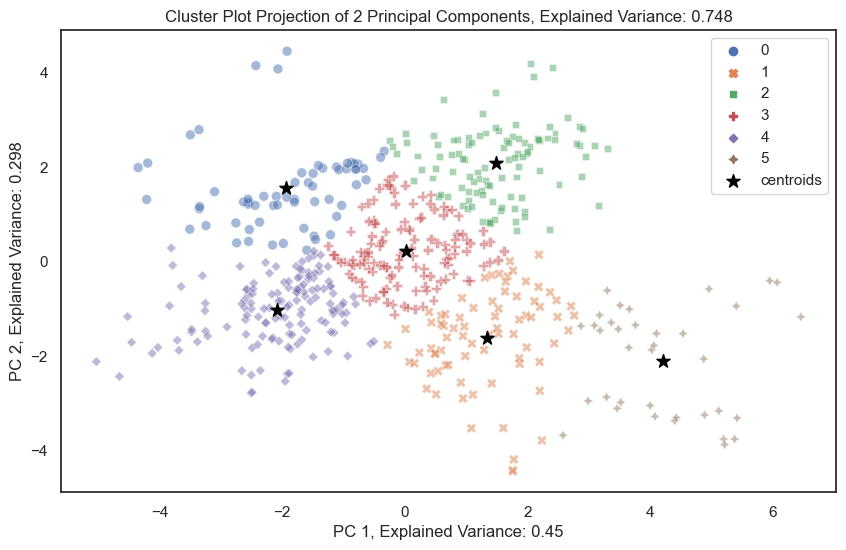

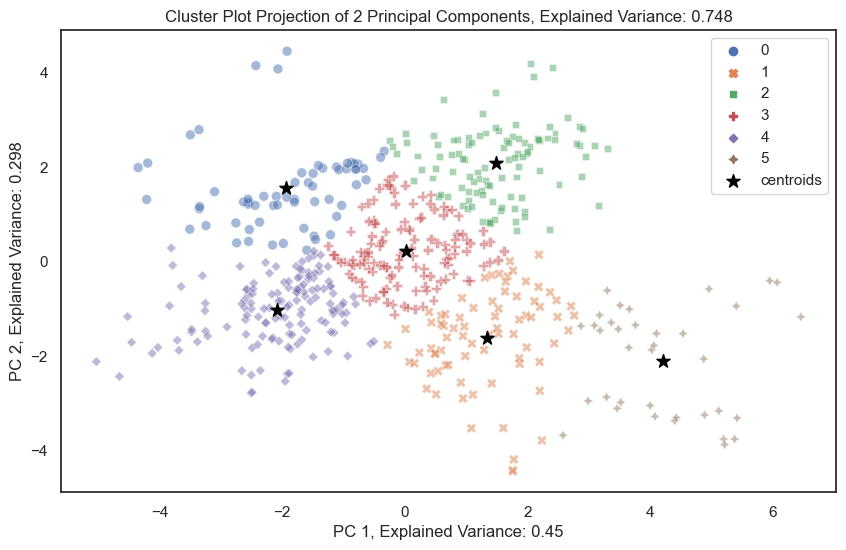

In [1099]:
pc12_cluster_plot(labeled_df, pca_exp_var_df, centroids_x, centroids_y)

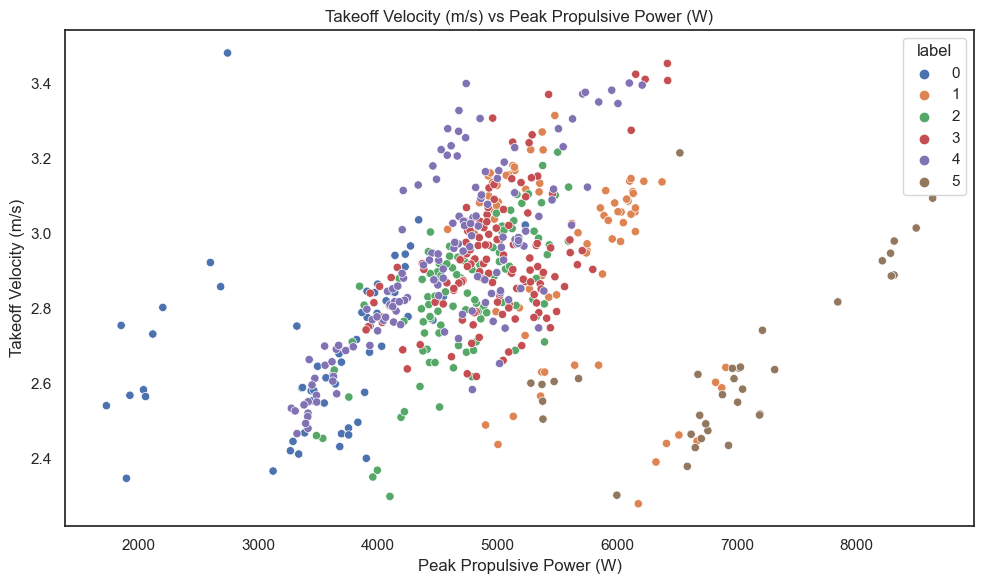

In [1100]:
cluster_peak_propul_power_scatter, ax = plt.subplots(1, 1, figsize=(10, 6), facecolor='white')

sns.scatterplot(
    data=labeled_df,
    x='peak_propulsive_power',
    y='takeoff_velocity',
    hue='label',
    # size=3
    # color='blue',
    # errorbar='se'
)
ax.set_title('Takeoff Velocity (m/s) vs Peak Propulsive Power (W)')
ax.set_ylabel('Takeoff Velocity (m/s)')
ax.set_xlabel('Peak Propulsive Power (W)')
# ax.axhline(y=100, color='gray', linestyle='--')
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
cluster_peak_propul_power_scatter.tight_layout()

/Users/chrisizenour/opt/anaconda3/envs/msu/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight

/Users/chrisizenour/opt/anaconda3/envs/msu/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



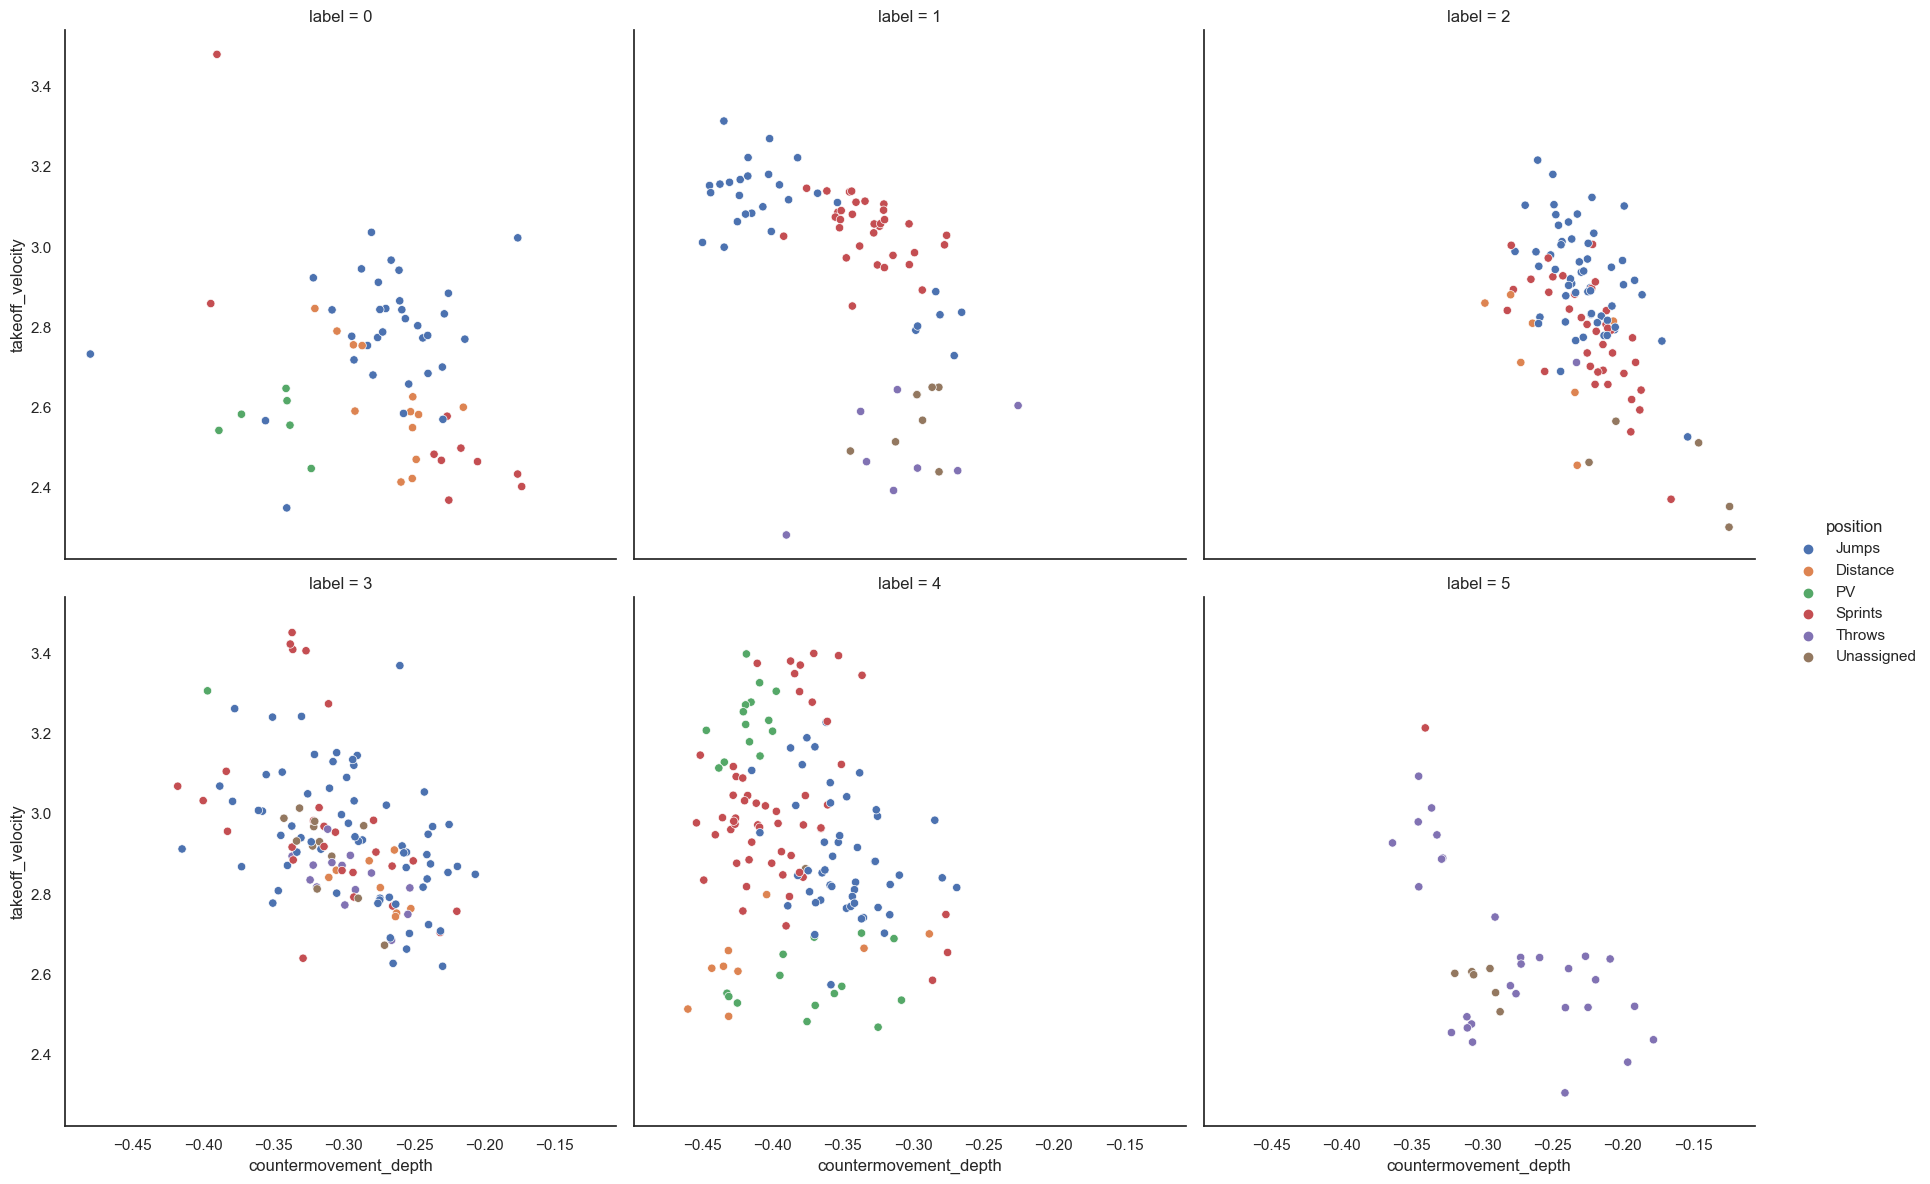

In [1101]:
cluster_takeoff_velo_cm_depth_relplot = sns.relplot(
    data=labeled_df,
    x='countermovement_depth',
    y='takeoff_velocity',
    col='label',
    hue='position',
    kind='scatter',
    col_wrap=3,
    height = 6,
    )
cluster_takeoff_velo_cm_depth_relplot.tight_layout()

/Users/chrisizenour/opt/anaconda3/envs/msu/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight

/Users/chrisizenour/opt/anaconda3/envs/msu/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



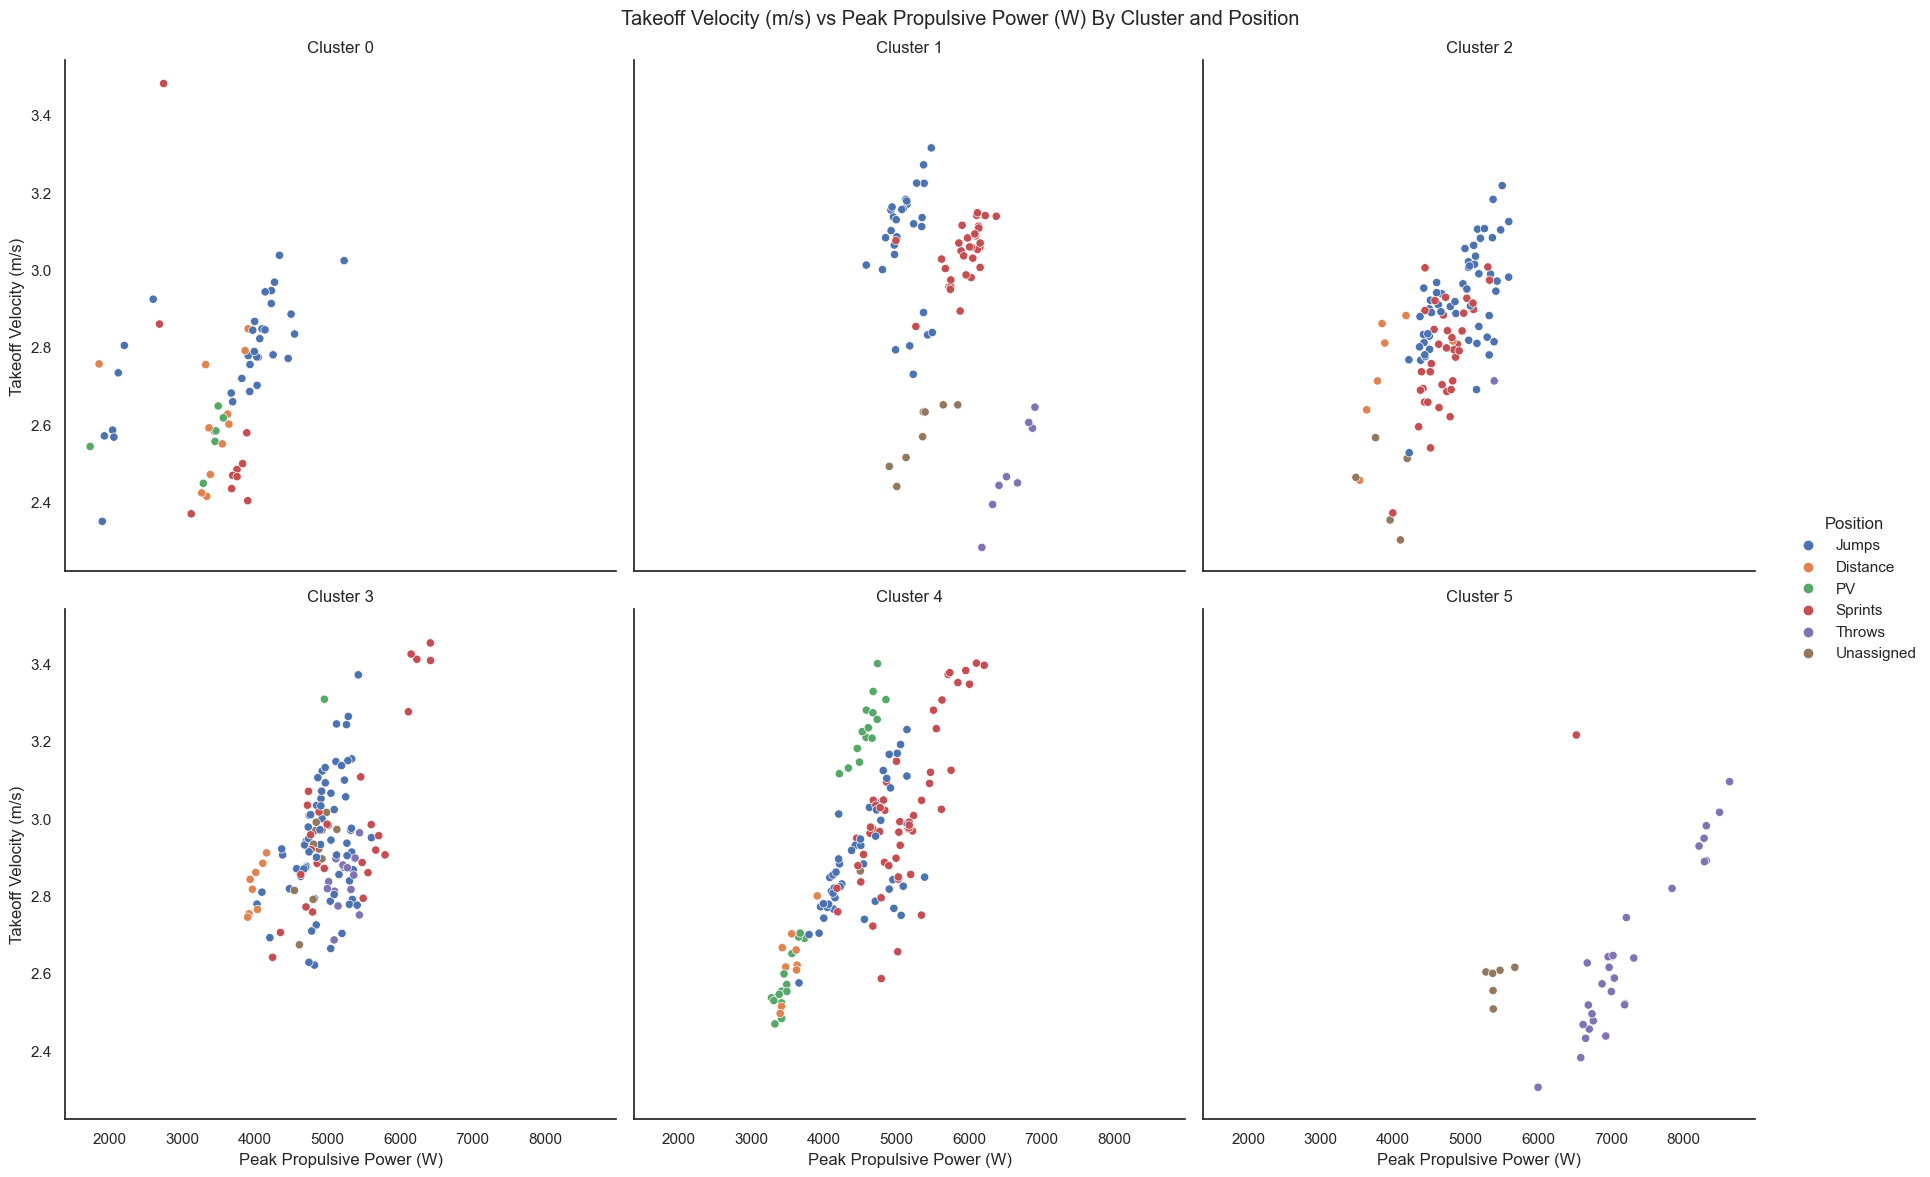

In [1102]:
cluster_takeoff_velo_peak_propul_relplot = sns.relplot(
    data=labeled_df,
    x='peak_propulsive_power',
    y='takeoff_velocity',
    col='label',
    hue='position',
    kind='scatter',
    col_wrap=3,
    height = 6,
    )
cluster_takeoff_velo_peak_propul_relplot.set_axis_labels('Peak Propulsive Power (W)', 'Takeoff Velocity (m/s)')
plt.subplots_adjust(top=0.9)
cluster_takeoff_velo_peak_propul_relplot.fig.suptitle('Takeoff Velocity (m/s) vs Peak Propulsive Power (W) By Cluster and Position')
cluster_takeoff_velo_peak_propul_relplot._legend.set_title("Position")
cluster_takeoff_velo_peak_propul_relplot.set_titles("Cluster {col_name}")
cluster_takeoff_velo_peak_propul_relplot.tight_layout()
cluster_takeoff_velo_peak_propul_relplot.savefig(f'{project_data_exports_path}/cluster_takeoff_velo_peak_proul_relplot.png', dpi=300, bbox_inches='tight', pad_inches=0.5)

/Users/chrisizenour/opt/anaconda3/envs/msu/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight

/Users/chrisizenour/opt/anaconda3/envs/msu/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



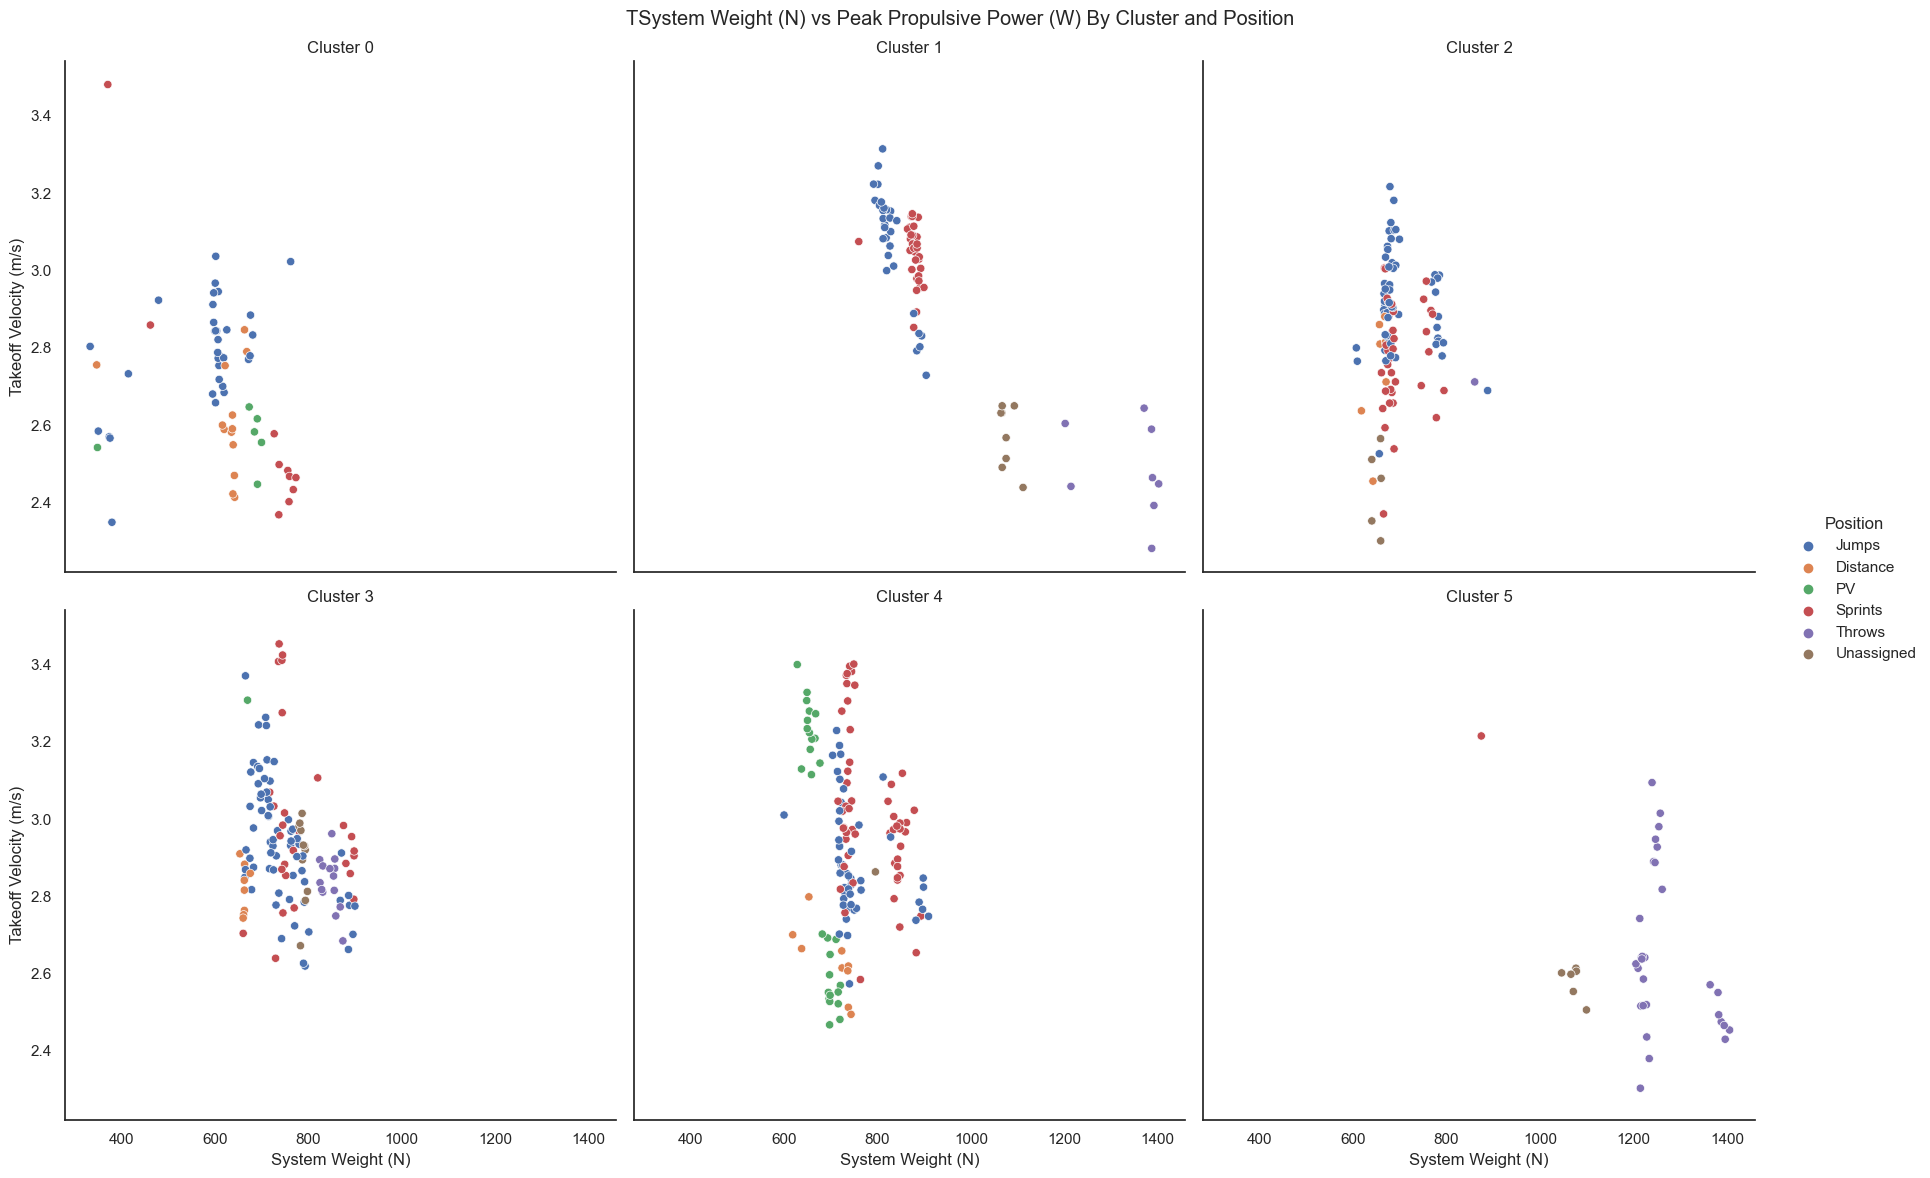

In [1103]:
cluster_takeoff_velo_sys_weight_relplot = sns.relplot(
    data=labeled_df,
    x='system_weight',
    y='takeoff_velocity',
    col='label',
    hue='position',
    kind='scatter',
    col_wrap=3,
    height = 6,
    )
cluster_takeoff_velo_sys_weight_relplot.set_axis_labels('System Weight (N)', 'Takeoff Velocity (m/s)')
plt.subplots_adjust(top=0.9)
cluster_takeoff_velo_sys_weight_relplot.fig.suptitle('TSystem Weight (N) vs Peak Propulsive Power (W) By Cluster and Position')
cluster_takeoff_velo_sys_weight_relplot._legend.set_title("Position")
cluster_takeoff_velo_sys_weight_relplot.set_titles("Cluster {col_name}")

cluster_takeoff_velo_sys_weight_relplot.tight_layout()
cluster_takeoff_velo_sys_weight_relplot.savefig(f'{project_data_exports_path}/cluster_takeoff_velo_sys_weight_relplot.png', dpi=300, bbox_inches='tight', pad_inches=0.5)

# Supervised Learning

In [1104]:
modeling_df = df.copy()
modeling_df

,testid,date,date_str,time,name,position,takeoff_velocity,system_weight,countermovement_depth,time_to_takeoff,unweighting_phase,braking_phase,peak_braking_power,force_at_min_displacement,propulsive_phase,peak_propulsive_power
0,OyBSC2ipcJDyXN1GBbfO,2022-03-22,2022-03-22,13:16:37,Aaron Williams,Sprints,3.2793,723.7908,-0.3716,1.086,0.588,0.238,-657.1589,1530,0.260,5509.0807
1,XHZJP0SoALY7n7WKHLZ5,2022-03-22,2022-03-22,14:07:05,Ammare Mayo,Sprints,3.0043,668.6937,-0.2793,0.673,0.315,0.132,-1391.1700,1843,0.226,4438.9458
2,ualCP0CeBSnJTb6HK0ge,2022-03-22,2022-03-22,12:59:59,Andrew Bosche,PV,2.6888,711.4374,-0.3135,0.916,0.396,0.195,-792.5835,1395,0.325,3730.7445
3,NKonsoCVgxjGBwD4JnLr,2022-03-22,2022-03-22,14:02:19,Chad Mowbray,Sprints,3.0468,744.8048,-0.4278,0.909,0.386,0.244,-1049.4055,1735,0.279,4820.3112
4,D9w5963nreWH7W3oneHV,2022-03-22,2022-03-22,14:03:20,Chase Knnor,Distance,2.6148,724.2543,-0.4430,1.005,0.399,0.244,-1145.4309,1373,0.362,3472.5154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,V0zaVvVWSXxF5rWYYcg5,2022-05-10,2022-05-10,13:11:00,Nick Page,Jumps,2.7237,770.9199,-0.2398,0.712,0.344,0.159,-1082.5908,1667,0.209,4846.5209
543,SnsQAejv3g5u7mDC9i7Q,2022-05-10,2022-05-10,13:18:37,Orion Frazier,Sprints,2.9729,888.7668,-0.3474,0.697,0.327,0.134,-2664.2897,2413,0.236,5748.4795
544,ugKiBtwelKxSroj9w87j,2022-05-10,2022-05-10,13:23:04,Terrance Gainer,Sprints,2.8829,749.5766,-0.2507,0.724,0.372,0.147,-1411.2698,1860,0.205,4858.5551
545,xCnD65gW6xtBl1LfXDFl,2022-05-10,2022-05-10,13:09:31,Will Rivers,Jumps,2.9127,720.0120,-0.4150,0.724,0.302,0.196,-1675.3063,1714,0.226,4747.4210


In [1105]:
modeling_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 547 entries, 0 to 546
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   testid                     547 non-null    object        
 1   date                       547 non-null    datetime64[ns]
 2   date_str                   547 non-null    object        
 3   time                       547 non-null    object        
 4   name                       547 non-null    object        
 5   position                   547 non-null    object        
 6   takeoff_velocity           547 non-null    float64       
 7   system_weight              547 non-null    float64       
 8   countermovement_depth      547 non-null    float64       
 9   time_to_takeoff            547 non-null    float64       
 10  unweighting_phase          547 non-null    float64       
 11  braking_phase              547 non-null    float64       
 12  peak_bra

In [1106]:
X = modeling_df.iloc[:, np.r_[5, 7:16]]
y = modeling_df.iloc[:, 6]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)
if isinstance(y_train, pd.Series):
    y_train = y_train.values.ravel()
if isinstance(y_test, pd.Series):
    y_test = y_test.values.ravel()
feature_names = X_train.columns
feature_names

Index(['position', 'system_weight', 'countermovement_depth', 'time_to_takeoff',
       'unweighting_phase', 'braking_phase', 'peak_braking_power',
       'force_at_min_displacement', 'propulsive_phase',
       'peak_propulsive_power'],
      dtype='object')

In [1107]:
numeric_features = make_column_selector(dtype_include=np.number)
numeric_features = numeric_features(X_train)
print(numeric_features)

numeric_transformer_non_tree = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('std_scaler', StandardScaler())])

numeric_transformer_tree = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))])

categorical_features = make_column_selector(dtype_include=[object, 'category'])
categorical_features = categorical_features(X_train)
print(categorical_features)

categorical_transformer = Pipeline(steps=[
    ('ohe', OneHotEncoder(handle_unknown='ignore', drop='first'))])

preprocessor_non_tree = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_non_tree, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

preprocessor_tree = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_tree, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

['system_weight', 'countermovement_depth', 'time_to_takeoff', 'unweighting_phase', 'braking_phase', 'peak_braking_power', 'force_at_min_displacement', 'propulsive_phase', 'peak_propulsive_power']
['position']


## Linear Regression

In [1108]:
lr_pipe = Pipeline([
    ('preprocessor', preprocessor_non_tree), 
    ('regressor', LinearRegression())
])

lr_model = lr_pipe.fit(X_train, y_train)

lr_preds = lr_model.predict(X_test)

lr_rmse = np.sqrt(mean_squared_error(y_test, lr_preds))
lr_r2 = r2_score(y_test, lr_preds)

print(f'R2: {lr_r2}')
print(f'RMSE: {lr_rmse}')

R2: 0.8771140016385794
RMSE: 0.07002097755733899


In [1109]:
lr_coefs = lr_model.named_steps['regressor'].coef_.flatten()
lr_intercept = lr_model.named_steps['regressor'].intercept_
lr_intercept_df = pd.DataFrame({'Feature': ['Intercept'], 'Coefficient': lr_intercept})

if 'preprocessor' in lr_pipe.named_steps:
    lr_feature_names_transformed = lr_pipe.named_steps['preprocessor'].get_feature_names_out()
    lr_coef_df = pd.DataFrame({'Feature': lr_feature_names_transformed, 'Coefficient': lr_coefs})
else:
    lr_coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': lr_coefs})
    
    
lr_coef_df = pd.concat([lr_intercept_df, lr_coef_df], ignore_index=True)
lr_coef_df.to_csv(f'{project_data_exports_path}/lr_coef_df.csv')
lr_coef_df

,Feature,Coefficient
0,Intercept,2.864748
1,num__system_weight,-0.317611
2,num__countermovement_depth,-0.100842
3,num__time_to_takeoff,0.005677
4,num__unweighting_phase,0.002539
5,num__braking_phase,-0.043414
6,num__peak_braking_power,0.022395
7,num__force_at_min_displacement,0.023251
8,num__propulsive_phase,0.054270
9,num__peak_propulsive_power,0.322085


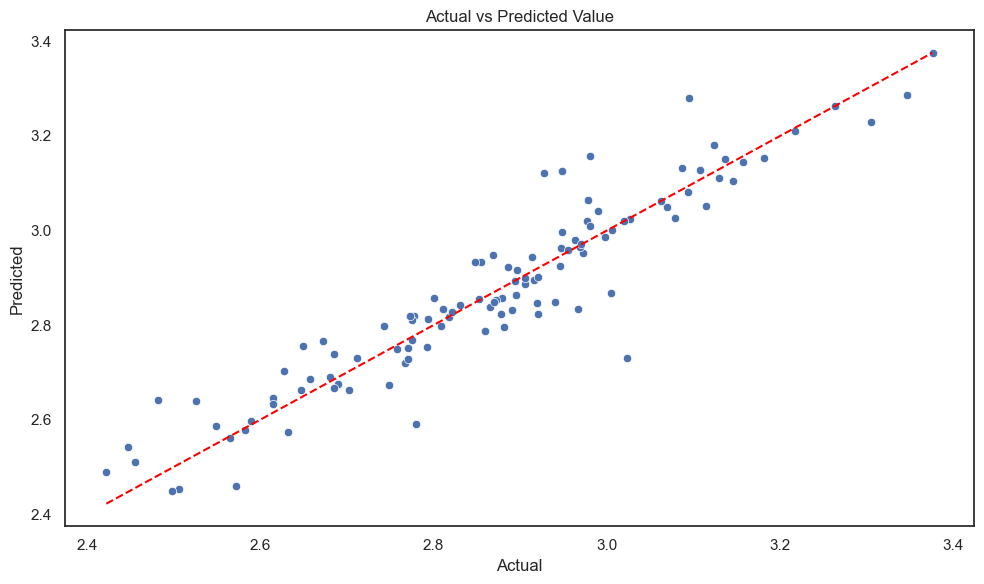

In [1110]:
lr_act_pred_plot, ax = plt.subplots(1,1, figsize=(10,6), facecolor='white')

sns.scatterplot(
    x=y_test,
    y=lr_preds,
)
ax.plot([y_test.min(), lr_preds.max()],
        [y_test.min(), lr_preds.max()],
        color='red', linestyle='--')

ax.set_title('Actual vs Predicted Value')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
lr_act_pred_plot.tight_layout()

## KNN - Regressor

In [1111]:
knn_pipe = Pipeline([
    ('preprocessor', preprocessor_non_tree), 
    ('regressor', KNeighborsRegressor())
])

knn_pipe.get_params()

knn_params = [{'regressor__n_neighbors': np.arange(1, 25, 1)}]

knn_gs = GridSearchCV(estimator=knn_pipe,
                      param_grid=knn_params,
                      cv=5,
                      scoring='neg_mean_squared_error',
                      verbose=1)

knn_scores = cross_val_score(knn_gs,
                             X_train,
                             y_train,
                             scoring='neg_mean_squared_error')

knn_gs.fit(X_train, y_train)
knn_best_params = knn_gs.best_params_
knn_best_pipe = knn_gs.best_estimator_
knn_best_pipe

knn_preds = knn_gs.predict(X_test)

knn_rmse = np.sqrt(mean_squared_error(y_test, knn_preds))
knn_r2 = r2_score(y_test, knn_preds)

print(f'R2: {knn_r2}')
print(f'RMSE: {knn_rmse}')

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
R2: 0.7038374204001718
RMSE: 0.10870313282158556


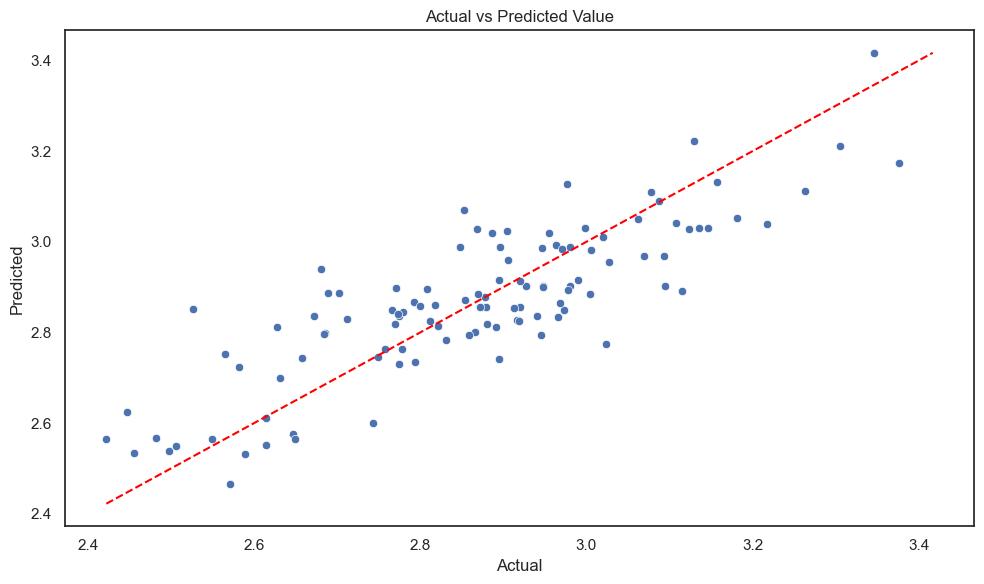

In [1112]:
knn_act_pred_plot, ax = plt.subplots(1,1, figsize=(10,6), facecolor='white')

sns.scatterplot(
    x=y_test,
    y=knn_preds,
)
ax.plot([y_test.min(), knn_preds.max()],
        [y_test.min(), knn_preds.max()],
        color='red', linestyle='--')

ax.set_title('Actual vs Predicted Value')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
knn_act_pred_plot.tight_layout()

## Decision Tree - Regressor

In [1113]:
tree_pipe = Pipeline([
    ('preprocssor', preprocessor_tree),
    ('regressor', DecisionTreeRegressor())
])

tree_pipe.get_params()

tree_params = [{'regressor__max_depth': [2, 3,],
                'regressor__min_samples_split': [2, 3, 4],
                'regressor__random_state': [0]}]

tree_gs = GridSearchCV(estimator=tree_pipe,
                       param_grid=tree_params,
                       cv=5,
                       scoring='neg_mean_squared_error',
                       verbose=1)

# tree_gs_results = pd.DataFrame(tree_gs.cv_results_)

tree_scores = cross_val_score(tree_gs,
                              X_train,
                              y_train,
                              scoring='neg_mean_squared_error')

tree_gs.fit(X_train, y_train)
tree_best_params = tree_gs.best_params_
tree_best_pipe = tree_gs.best_estimator_

tree_preds = tree_gs.predict(X_test)

tree_rmse = np.sqrt(mean_squared_error(y_test, tree_preds))
tree_r2 = r2_score(y_test, tree_preds)

print(f'Tree R2: {tree_r2}')
print(f'Tree RMSE: {tree_rmse}')

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Tree R2: 0.4544889923485327
Tree RMSE: 0.14752945150773192


Text(0.5, 1.0, 'Best Decision Tree from Grid Search')

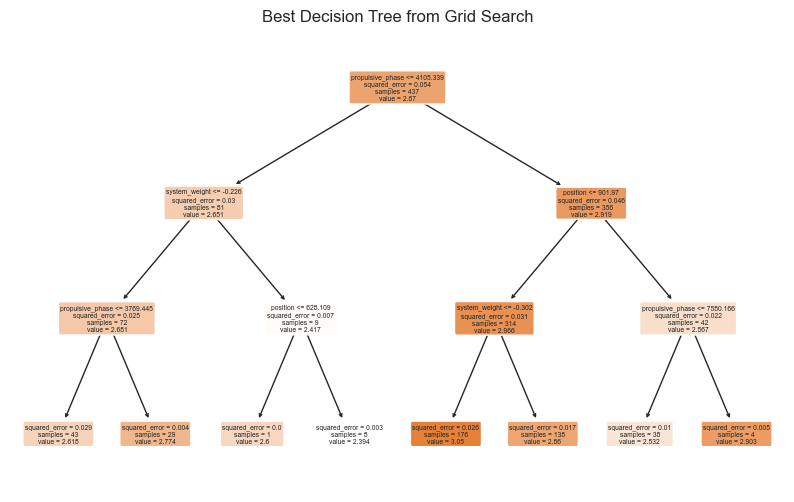

In [1114]:
tree_plot, ax = plt.subplots(1, 1, figsize=(10, 6), facecolor='white')

plot_tree(tree_best_pipe.named_steps['regressor'], filled=True, feature_names=feature_names, rounded=True)

ax.set_title('Best Decision Tree from Grid Search')


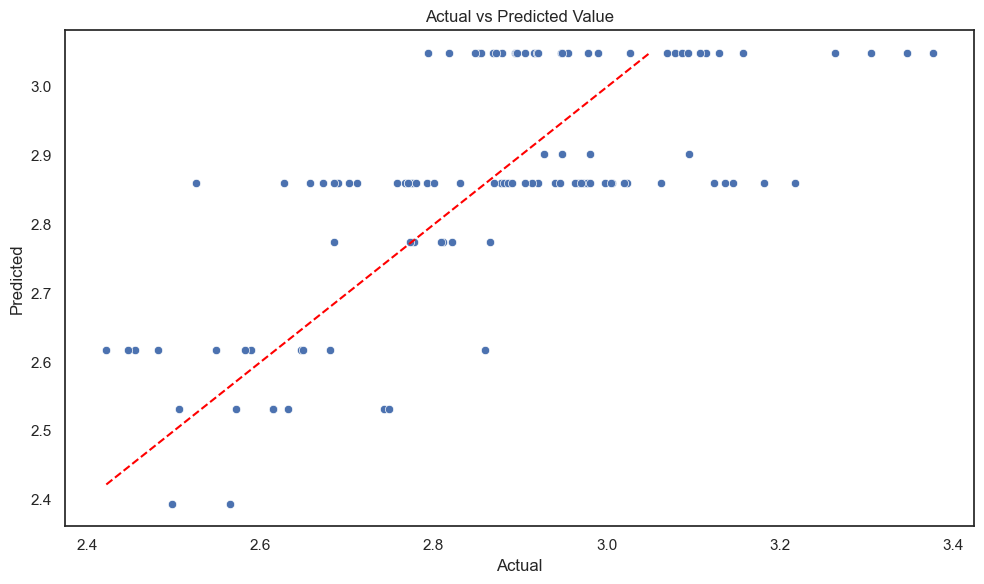

In [1115]:
tree_act_pred_plot, ax = plt.subplots(1,1, figsize=(10,6), facecolor='white')

sns.scatterplot(
    x=y_test,
    y=tree_preds,
)
ax.plot([y_test.min(), tree_preds.max()],
        [y_test.min(), tree_preds.max()],
        color='red', linestyle='--')

ax.set_title('Actual vs Predicted Value')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
tree_act_pred_plot.tight_layout()

## Random Forest - Regressor

In [1116]:
rf_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor_tree),
    ('regressor', RandomForestRegressor())
])
rf_pipe.get_params()

rf_params = [{'regressor__n_estimators': [500],
              'regressor__max_depth': [1, 2, 3, 4],
              'regressor__random_state': [0]}]

rf_gs = GridSearchCV(estimator=rf_pipe,
                     param_grid=rf_params,
                     cv=5,
                     scoring='neg_mean_squared_error',
                     verbose=1)

rf_scores = cross_val_score(rf_gs,
                            X_train,
                            y_train,
                            scoring='neg_mean_squared_error')

rf_gs.fit(X_train, y_train)
rf_best_params = rf_gs.best_params_
rf_best_pipe = rf_gs.best_estimator_

rf_preds = rf_gs.predict(X_test)

rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
rf_r2 = r2_score(y_test, rf_preds)

print(f'RF R2: {rf_r2}')
print(f'RF RMSE: {rf_rmse}')

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
RF R2: 0.6224857350735209
RF RMSE: 0.1227279985804526


In [1117]:
rf_feature_importances = rf_best_pipe.named_steps['regressor'].feature_importances_

if 'preprocessor' in rf_best_pipe.named_steps:
    rf_feature_names_transformed = rf_best_pipe.named_steps['preprocessor'].get_feature_names_out()
    rf_feature_importances_df = pd.DataFrame({'Feature': rf_feature_names_transformed, 'Importance': rf_feature_importances}).sort_values(by=['Importance'], ascending=False)
else:
    rf_feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': rf_feature_importances}).sort_values(by=['Importance'], ascending=False)
    
rf_feature_importances_df

,Feature,Importance
8,num__peak_propulsive_power,0.411304
0,num__system_weight,0.254528
1,num__countermovement_depth,0.205635
6,num__force_at_min_displacement,0.071854
7,num__propulsive_phase,0.016172
4,num__braking_phase,0.011197
11,cat__position_Sprints,0.009578
5,num__peak_braking_power,0.008326
9,cat__position_Jumps,0.004902
3,num__unweighting_phase,0.002458


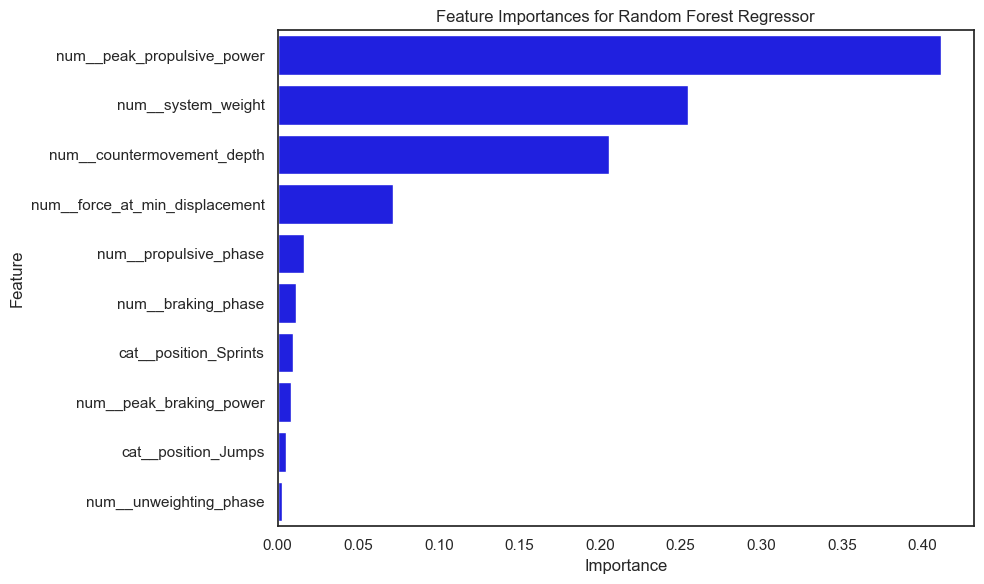

In [1118]:
rf_feature_importances_plot, ax = plt.subplots(1, 1, figsize=(10,6))

sns.barplot(
    data=rf_feature_importances_df.head(10),
    x='Importance',
    y='Feature',
    color='blue',
    ax=ax
)
ax.set_title('Feature Importances for Random Forest Regressor')
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')

rf_feature_importances_plot.tight_layout()
rf_feature_importances_plot.savefig(f'{project_data_exports_path}/rf_feature_importances_plot.png', dpi=300)

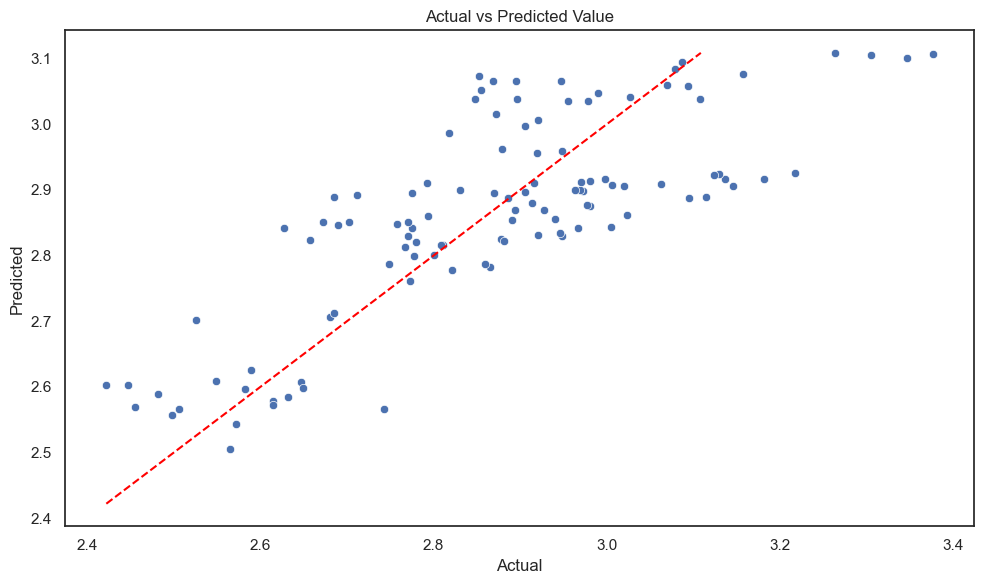

In [1119]:
rf_act_pred_plot, ax = plt.subplots(1,1, figsize=(10,6), facecolor='white')

sns.scatterplot(
    x=y_test,
    y=rf_preds,
)
ax.plot([y_test.min(), rf_preds.max()],
        [y_test.min(), rf_preds.max()],
        color='red', linestyle='--')

ax.set_title('Actual vs Predicted Value')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
rf_act_pred_plot.tight_layout()

## XGBoost - Regressor

In [1120]:
xgb_pipe = Pipeline([
    ('preprocessor', preprocessor_tree),
    ('regressor', XGBRegressor())
])

xgb_pipe.get_params()

xgb_params = [{'regressor__n_estimators': [100, 200],
               'regressor__max_depth': [2, 3, 4, 5, 6, 7],
               'regressor__learning_rate': [0.01, 0.05, 0.1],
               'regressor__subsample': [0.7, 0.8, 1.0],
               'regressor__colsample_bytree': [0.7, 0.8, 1.0]}]

xgb_gs = GridSearchCV(estimator=xgb_pipe,
                      param_grid=xgb_params,
                      cv=5,
                      scoring='neg_mean_squared_error',
                      verbose=1)
xgb_gs.fit(X_train, y_train)
xgb_best_params = xgb_gs.best_params_
xgb_best_pipe = xgb_gs.best_estimator_

xgb_preds = xgb_gs.predict(X_test)

xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
xgb_r2 = r2_score(y_test, xgb_preds)

print(f'XGB R2: {xgb_r2}')
print(f'XGB RMSE: {xgb_rmse}')

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
XGB R2: 0.8755251718973031
XGB RMSE: 0.07047218484920181


In [1121]:
xgb_feature_importances = xgb_best_pipe.named_steps['regressor'].feature_importances_

if 'preprocessor' in xgb_best_pipe.named_steps:
    xgb_feature_names_transformed = xgb_best_pipe.named_steps['preprocessor'].get_feature_names_out()
    xgb_feature_importances_df = pd.DataFrame({'Feature': xgb_feature_names_transformed, 'Importance': xgb_feature_importances}).sort_values(by=['Importance'], ascending=False)
else:
    xgb_feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': xgb_feature_importances}).sort_values(by=['Importance'], ascending=False)
    
xgb_feature_importances_df

,Feature,Importance
10,cat__position_PV,0.214648
8,num__peak_propulsive_power,0.146777
9,cat__position_Jumps,0.121702
11,cat__position_Sprints,0.104179
0,num__system_weight,0.093148
1,num__countermovement_depth,0.086906
6,num__force_at_min_displacement,0.085669
7,num__propulsive_phase,0.047464
12,cat__position_Throws,0.037220
5,num__peak_braking_power,0.024197


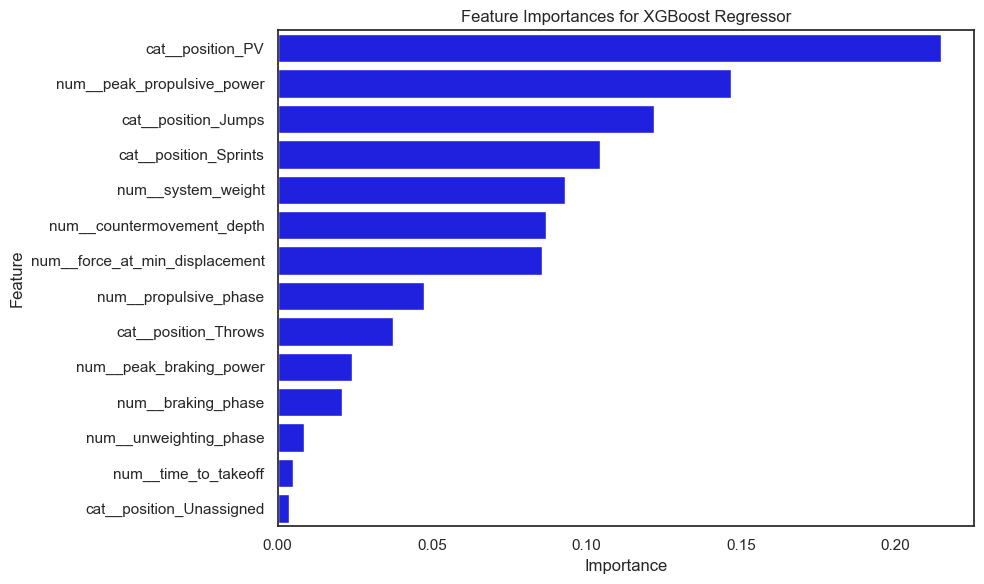

In [1122]:
xgb_feature_importances_plot, ax = plt.subplots(1, 1, figsize=(10,6))

sns.barplot(
    data=xgb_feature_importances_df.head(20),
    x='Importance',
    y='Feature',
    color='blue',
    ax=ax
)
ax.set_title('Feature Importances for XGBoost Regressor')
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')

xgb_feature_importances_plot.tight_layout()
xgb_feature_importances_plot.savefig(f'{project_data_exports_path}/xgb_feature_importances_plot.png', dpi=300)

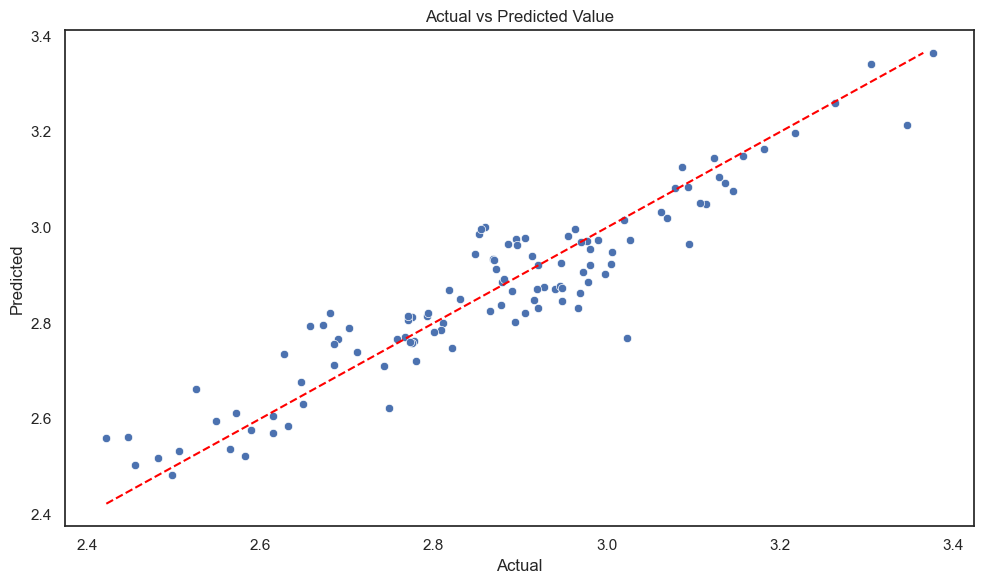

In [1123]:
xgb_act_pred_plot, ax = plt.subplots(1,1, figsize=(10,6), facecolor='white')

sns.scatterplot(
    x=y_test,
    y=xgb_preds,
)
ax.plot([y_test.min(), xgb_preds.max()],
        [y_test.min(), xgb_preds.max()],
        color='red', linestyle='--')

ax.set_title('Actual vs Predicted Value')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
xgb_act_pred_plot.tight_layout()

## Ridge - Regressor

In [1124]:
ridge_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor_non_tree),
    ('regressor', Ridge())
])

ridge_pipe.get_params()

ridge_params = [{'regressor__alpha': np.arange(0.01, 1, 0.005),
                 'regressor__fit_intercept': [True, False],
                 # 'regressor__normalize': [True, False],
                 'regressor__random_state': [0]}]

ridge_gs = GridSearchCV(estimator=ridge_pipe,
                        param_grid=ridge_params,
                        cv=5,
                        scoring='neg_mean_squared_error',
                        verbose=1)

ridge_scores = cross_val_score(ridge_gs,
                               X_train,
                               y_train,
                               scoring='neg_mean_squared_error')

ridge_gs.fit(X_train, y_train)
ridge_best_params = ridge_gs.best_params_
ridge_best_pipe = ridge_gs.best_estimator_

ridge_preds = ridge_gs.predict(X_test)

ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_preds))
ridge_r2 = r2_score(y_test, ridge_preds)

print(f'Ridge R2: {ridge_r2}')
print(f'Ridge RMSE: {ridge_rmse}')

Fitting 5 folds for each of 396 candidates, totalling 1980 fits
Fitting 5 folds for each of 396 candidates, totalling 1980 fits
Fitting 5 folds for each of 396 candidates, totalling 1980 fits
Fitting 5 folds for each of 396 candidates, totalling 1980 fits
Fitting 5 folds for each of 396 candidates, totalling 1980 fits
Fitting 5 folds for each of 396 candidates, totalling 1980 fits
Ridge R2: 0.8765090810204534
Ridge RMSE: 0.07019310918550954


In [1125]:
ridge_coefs = ridge_best_pipe.named_steps['regressor'].coef_.flatten()
ridge_intercept = ridge_best_pipe.named_steps['regressor'].intercept_
ridge_intercept_df = pd.DataFrame({'Feature': ['Intercept'], 'Coefficient': ridge_intercept})

if 'preprocessor' in ridge_pipe.named_steps:
    ridge_feature_names_transformed = ridge_best_pipe.named_steps['preprocessor'].get_feature_names_out()
    ridge_coef_df = pd.DataFrame({'Feature': ridge_feature_names_transformed, 'Coefficient': ridge_coefs})
else:
    ridge_coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': ridge_coefs})
    
    
ridge_coef_df = pd.concat([ridge_intercept_df, ridge_coef_df], ignore_index=True)
ridge_coef_df

,Feature,Coefficient
0,Intercept,2.864000
1,num__system_weight,-0.311715
2,num__countermovement_depth,-0.102776
3,num__time_to_takeoff,0.004843
4,num__unweighting_phase,0.003047
5,num__braking_phase,-0.043728
6,num__peak_braking_power,0.021738
7,num__force_at_min_displacement,0.019331
8,num__propulsive_phase,0.051211
9,num__peak_propulsive_power,0.319036


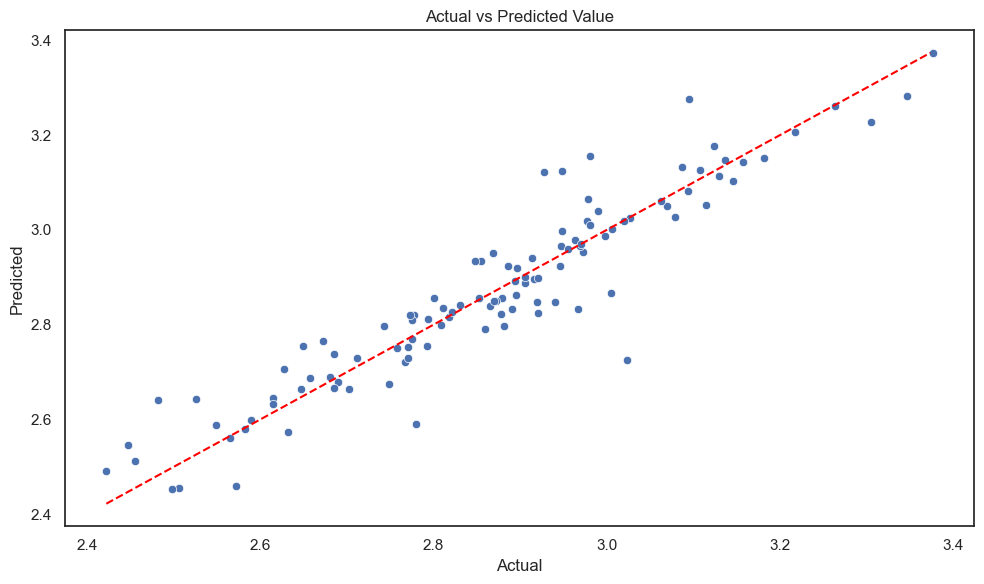

In [1126]:
ridge_act_pred_plot, ax = plt.subplots(1,1, figsize=(10,6), facecolor='white')

sns.scatterplot(
    x=y_test,
    y=ridge_preds,
)
ax.plot([y_test.min(), ridge_preds.max()],
        [y_test.min(), ridge_preds.max()],
        color='red', linestyle='--')

ax.set_title('Actual vs Predicted Value')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ridge_act_pred_plot.tight_layout()

## LASSO - Regressor

In [1127]:
lasso_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor_non_tree),
    ('regressor', Lasso(max_iter=10000))
])

lasso_pipe.get_params()

lasso_params = [{'regressor__alpha': np.arange(0.01, 1, 0.05),
                 'regressor__fit_intercept': [True, False],
                 # 'regressor__normalize': [True, False],
                 'regressor__random_state': [0]}]

lasso_gs = GridSearchCV(estimator=lasso_pipe,
                        param_grid=lasso_params,
                        cv=5,
                        scoring='neg_mean_squared_error',
                        verbose=1)

lasso_scores = cross_val_score(lasso_gs,
                               X_train,
                               y_train,
                               scoring='neg_mean_squared_error')

lasso_gs.fit(X_train, y_train)
lasso_best_params = lasso_gs.best_params_
lasso_best_pipe = lasso_gs.best_estimator_

lasso_preds = lasso_gs.predict(X_test)

lasso_rmse = np.sqrt(mean_squared_error(y_test, lasso_preds))
lasso_r2 = r2_score(y_test, lasso_preds)

print(f'LASSO R2: {lasso_r2}')
print(f'LASSO RMSE: {lasso_rmse}')

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
LASSO R2: 0.8473146676753077
LASSO RMSE: 0.0780504889175393


In [1128]:
lasso_coefs = lasso_best_pipe.named_steps['regressor'].coef_.flatten()
lasso_intercept = lasso_best_pipe.named_steps['regressor'].intercept_
lasso_intercept_df = pd.DataFrame({'Feature': ['Intercept'], 'Coefficient': lasso_intercept})

if 'preprocessor' in lasso_pipe.named_steps:
    lasso_feature_names_transformed = lasso_best_pipe.named_steps['preprocessor'].get_feature_names_out()
    lasso_coef_df = pd.DataFrame({'Feature': lasso_feature_names_transformed, 'Coefficient': lasso_coefs})
else:
    lasso_coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': lasso_coefs})
    
    
lasso_coef_df = pd.concat([lasso_intercept_df, lasso_coef_df], ignore_index=True)
lasso_coef_df

,Feature,Coefficient
0,Intercept,2.865018
1,num__system_weight,-0.249113
2,num__countermovement_depth,-0.104934
3,num__time_to_takeoff,0.000000
4,num__unweighting_phase,0.002027
5,num__braking_phase,-0.005341
6,num__peak_braking_power,-0.000000
7,num__force_at_min_displacement,-0.000000
8,num__propulsive_phase,0.000000
9,num__peak_propulsive_power,0.249004


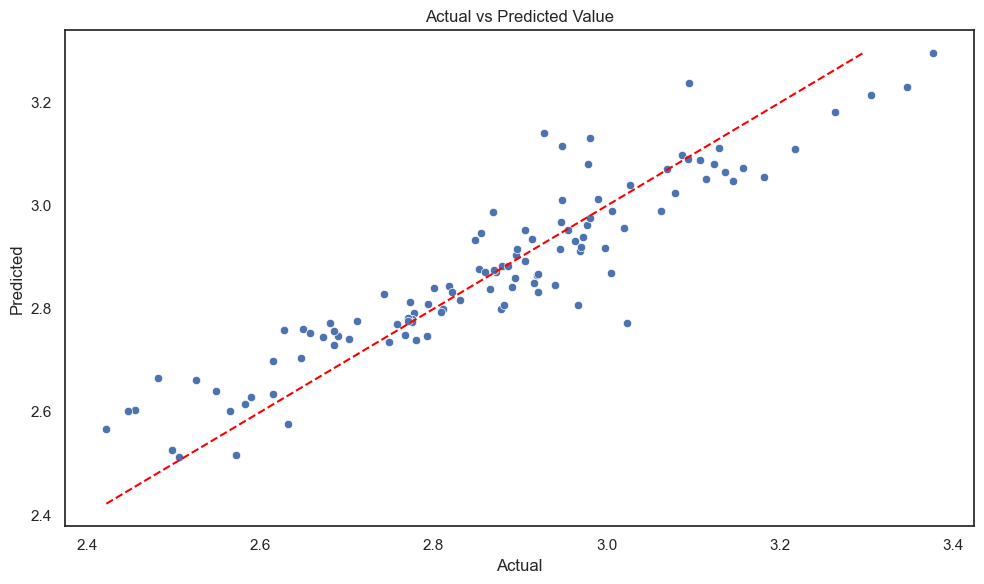

In [1129]:
lasso_act_pred_plot, ax = plt.subplots(1,1, figsize=(10,6), facecolor='white')

sns.scatterplot(
    x=y_test,
    y=lasso_preds,
)
ax.plot([y_test.min(), lasso_preds.max()],
        [y_test.min(), lasso_preds.max()],
        color='red', linestyle='--')

ax.set_title('Actual vs Predicted Value')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
lasso_act_pred_plot.tight_layout()

### Merge Ridge & LASSO Coefficient DFs

In [1130]:
ridge_lasso_coef_df = pd.merge(ridge_coef_df, lasso_coef_df, on=['Feature'])
ridge_lasso_coef_df = ridge_lasso_coef_df.rename(columns={
    'Coefficient_x': 'Ridge Coefficient',
    'Coefficient_y': 'LASSO Coefficient'
})
ridge_lasso_coef_df

,Feature,Ridge Coefficient,LASSO Coefficient
0,Intercept,2.864000,2.865018
1,num__system_weight,-0.311715,-0.249113
2,num__countermovement_depth,-0.102776,-0.104934
3,num__time_to_takeoff,0.004843,0.000000
4,num__unweighting_phase,0.003047,0.002027
5,num__braking_phase,-0.043728,-0.005341
6,num__peak_braking_power,0.021738,-0.000000
7,num__force_at_min_displacement,0.019331,-0.000000
8,num__propulsive_phase,0.051211,0.000000
9,num__peak_propulsive_power,0.319036,0.249004
